In [1]:
!pip install openeo rasterio folium geopandas sentinelhub matplotlib seaborn plotly requests

In [2]:
import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
import rasterio
from datetime import datetime, timedelta
import folium
from sentinelhub import SHConfig, BBox, CRS, MimeType, DataCollection, SentinelHubRequest, bbox_to_dimensions
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from io import BytesIO
from PIL import Image
warnings.filterwarnings('ignore')


C:\Users\manop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
lago_atitlan = {
    "west": -91.326256,
    "east": -91.07151,
    "south": 14.5948,
    "north": 14.750979
}

lago_amatitlan = {
    "west": -90.638065,
    "east": -90.512924,
    "south": 14.412347,
    "north": 14.493799
}
start_date = "2024-01-01"
end_date = "2024-07-31"

print(f"Período de análisis: {start_date} a {end_date}")
duration = (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days
print(f"Duración: {duration} días ({duration/30:.1f} meses)")


Período de análisis: 2024-01-01 a 2024-07-31
Duración: 212 días (7.1 meses)


In [4]:
def setup_real_connections():
    try:
        connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
        
        collections = connection.list_collections()
        sentinel_collections = []
        for c in collections:
            try:
                if 'sentinel' in c['id'].lower():
                    sentinel_collections.append(c['id'])
            except Exception:
                continue
        
        print(f"Colecciones Sentinel disponibles: {len(sentinel_collections)}")

        config = SHConfig()
        config.sh_client_id = 'c02eac78-6a59-4c33-b10e-bfbc596293f8'
        config.sh_client_secret = 'uy82TTniaWG15EYJsq2h8DRQpod3Beer'
        config.save()
        print("Configuración Sentinel Hub guardada")
        
        return connection, config
    except Exception as e:
        print(f"Error en configuración: {e}")
        return None, None


In [5]:
cyanobacteria_evalscript = """
//VERSION=3
// Cyanobacteria detection script
// Based on official Sentinel Hub script from custom-scripts repository

function setup() {
    return {
        input: ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
        output: { 
            bands: 4,
            sampleType: "FLOAT32"
        }
    };
}

// Water body detection function
function isWater(sample) {
    let mndwi = (sample.B03 - sample.B11) / (sample.B03 + sample.B11 + 0.001);
    let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08 + 0.001);
    let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 0.001);
    
    // Water detection criteria
    return (mndwi > 0.42 || ndwi > 0.4 || ndvi < -0.2);
}

function evaluatePixel(sample) {
    let water = isWater(sample) ? 1.0 : 0.0;
    
    if (water > 0) {
        // NDCI (Normalized Difference Chlorophyll Index)
        let ndci = (sample.B05 - sample.B04) / (sample.B05 + sample.B04 + 0.001);
        
        // FAI (Floating Algal Index) 
        let fai = sample.B07 - sample.B04 - (sample.B8A - sample.B04) * (783 - 665) / (865 - 665);
        
        // Chlorophyll-a concentration (cyanobacteria proxy)
        let chl_a = Math.max(0, 826.57 * Math.pow(ndci, 3) - 176.43 * Math.pow(ndci, 2) + 19 * ndci + 4.071);
        chl_a = Math.min(chl_a, 100); // Cap at 100 μg/L
        
        // Additional spectral indices
        let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 0.001);
        let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08 + 0.001);
        
        return [chl_a, ndci, fai, ndwi];
    } else {
        return [0.0, 0.0, 0.0, 0.0];
    }
}
"""

In [6]:
def create_sentinel_hub_request(bbox, time_range, config):
    try:
        bbox_coords = BBox(
            bbox=[bbox['west'], bbox['south'], bbox['east'], bbox['north']], 
            crs=CRS.WGS84
        )
        size = bbox_to_dimensions(bbox_coords, resolution=60)
        
        request = SentinelHubRequest(
            evalscript=cyanobacteria_evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_range,
                    mosaicking_order='leastCC',
                    maxcc=0.3
                )
            ],
            responses=[
                SentinelHubRequest.output_response('default', MimeType.TIFF)
            ],
            bbox=bbox_coords,
            size=size,
            config=config,
            data_folder='data'
        )
        
        return request, size
        
    except Exception as e:
        print(f"Error creando solicitud Sentinel Hub: {e}")
        return None, None


In [7]:
def download_sentinel_hub_data(request, lake_name):
    try:
        print(f"Descargando datos de Sentinel Hub para {lake_name}...")
        response = request.get_data(save_data=True)
        
        if response and len(response) > 0:
            data = response[0]
            
            print(f" Datos descargados para {lake_name}")
            print(f"  Forma: {data.shape}")
            print(f"  Tipo: {data.dtype}")
            chl_a = data[:, :, 0]
            ndci = data[:, :, 1]
            fai = data[:, :, 2]  
            ndwi = data[:, :, 3]      
            water_mask = (chl_a > 0).astype(float)
            
            return {
                'chl_a': chl_a,
                'ndci': ndci,
                'fai': fai,
                'ndwi': ndwi,
                'water_mask': water_mask,
                'shape': data.shape
            }
        else:
            print(f"No se obtuvieron datos para {lake_name}")
            return None
            
    except Exception as e:
        print(f"Error descargando datos para {lake_name}: {e}")
        return None

In [8]:
def download_openeo_data(connection, bbox, start_date, end_date, lake_name):
    try:
        print(f"Descargando datos OpenEO para {lake_name}...")
        datacube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent={
                "west": bbox["west"], 
                "east": bbox["east"], 
                "south": bbox["south"], 
                "north": bbox["north"]
            },
            temporal_extent=[start_date, end_date],
            bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
        )

        datacube = datacube.filter_bbox(**bbox)
        datacube = datacube.resample_spatial(resolution=60)
        job = datacube.create_job(
            title=f"Cyanobacteria_Analysis_{lake_name}",
            description=f"Descarga de datos Sentinel-2 para análisis de cianobacterias en {lake_name}"
        )
        print("Ejecutando...")

        job.start_and_wait()
        
        if job.status() == "finished":
            results = job.get_results()
            print(f"Descarga completada para {lake_name}")
            return results
        else:
            print(f"Job falló para {lake_name}: {job.status()}")
            return None
            
    except Exception as e:
        print(f"Error OpenEO para {lake_name}: {e}")
        return None


In [9]:
def process_real_data(data_dict, lake_name):
    if data_dict is None:
        return None
        
    try:
        chl_a = data_dict['chl_a']
        water_mask = data_dict['water_mask']
        water_pixels = chl_a[water_mask > 0]
        
        if len(water_pixels) > 0:
            stats = {
                'mean_chl_a': np.mean(water_pixels),
                'max_chl_a': np.max(water_pixels),
                'min_chl_a': np.min(water_pixels),
                'std_chl_a': np.std(water_pixels),
                'water_pixel_count': len(water_pixels),
                'total_pixels': chl_a.size,
                'water_percentage': len(water_pixels) / chl_a.size * 100
            }
            
            print(f"Clorofila-a promedio: {stats['mean_chl_a']:.2f} μg/L")
            print(f"Clorofila-a máxima: {stats['max_chl_a']:.2f} μg/L")
            print(f"Píxeles de agua: {stats['water_pixel_count']} ({stats['water_percentage']:.1f}%)")
            
            return stats
        else:
            print(f"No se detectaron píxeles de agua en {lake_name}")
            return None
            
    except Exception as e:
        print(f"Error procesando datos de {lake_name}: {e}")
        return None

In [10]:
def download_temporal_data(connection, config, bbox, lake_name, start_date, end_date, frequency='30D'):
    temporal_data = {}
    dates = pd.date_range(start=start_date, end=end_date, freq=frequency)
    
    print(f"\nDescargando serie temporal para {lake_name}")
    print(f"Fechas a procesar: {len(dates)}")
    
    for i, date in enumerate(dates):
        try:
            start_window = (date - timedelta(days=7)).strftime('%Y-%m-%d')
            end_window = (date + timedelta(days=7)).strftime('%Y-%m-%d')
            
            print(f"procesando fecha {i+1}/{len(dates)}: {date.strftime('%Y-%m-%d')}")

            request, size = create_sentinel_hub_request(
                bbox, 
                (start_window, end_window), 
                config
            )
            
            if request:
                data = download_sentinel_hub_data(request, f"{lake_name}_{date.strftime('%Y%m%d')}")
                
                if data:
                    temporal_data[date.strftime('%Y-%m-%d')] = {
                        'date': date,
                        'data': data,
                        'stats': process_real_data(data, f"{lake_name}_{date.strftime('%Y-%m-%d')}")
                    }
                    print(f"Datos guardados para {date.strftime('%Y-%m-%d')}")
                else:
                    print(f"mo hay datos para {date.strftime('%Y-%m-%d')}")
            import time
            time.sleep(2)
            
        except Exception as e:
            print(f"Error procesando {date.strftime('%Y-%m-%d')}: {e}")
            continue
    
    print(f"Serie temporal completada: {len(temporal_data)} fechas exitosas")
    return temporal_data

In [11]:
def analyze_real_temporal_data(temporal_data, lake_name):
    dates = []
    mean_chl_a = []
    max_chl_a = []
    water_pixels = []
    
    for date_str, entry in temporal_data.items():
        if entry['stats']:
            dates.append(pd.to_datetime(date_str))
            mean_chl_a.append(entry['stats']['mean_chl_a'])
            max_chl_a.append(entry['stats']['max_chl_a'])
            water_pixels.append(entry['stats']['water_pixel_count'])
    
    if len(dates) == 0:
        print(f"No hay datos válidos para análisis temporal de {lake_name}")
        return None
    
    df = pd.DataFrame({
        'date': dates,
        'mean_chl_a': mean_chl_a,
        'max_chl_a': max_chl_a,
        'water_pixels': water_pixels
    })
    if len(mean_chl_a) > 0:
        threshold = np.percentile(mean_chl_a, 75)
        df['bloom_event'] = df['mean_chl_a'] > threshold
        
        print(f"\nANÁLISIS TEMPORAL - {lake_name.upper()}")
        print(f"Observaciones válidas: {len(df)}")
        print(f"Concentración promedio: {np.mean(mean_chl_a):.2f} μg/L")
        print(f"Concentración máxima: {np.max(max_chl_a):.2f} μg/L")
        print(f"Eventos de floración: {df['bloom_event'].sum()}")
    
    return df

In [12]:
def plot_real_temporal_evolution(df_atitlan, df_amatitlan):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    if df_atitlan is not None and len(df_atitlan) > 0:
        axes[0,0].plot(df_atitlan['date'], df_atitlan['mean_chl_a'], 'b-o', 
                      label='Atitlán', markersize=6, linewidth=2)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        axes[0,0].plot(df_amatitlan['date'], df_amatitlan['mean_chl_a'], 'r-s', 
                      label='Amatitlán', markersize=6, linewidth=2)
    
    axes[0,0].set_title('Evolución Temporal - Clorofila-a Promedio', fontsize=12)
    axes[0,0].set_ylabel('Clorofila-a')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    if df_atitlan is not None and len(df_atitlan) > 0:
        axes[0,1].plot(df_atitlan['date'], df_atitlan['max_chl_a'], 'b-o', 
                      label='Atitlán', markersize=6, linewidth=2)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        axes[0,1].plot(df_amatitlan['date'], df_amatitlan['max_chl_a'], 'r-s', 
                      label='Amatitlán', markersize=6, linewidth=2)
    
    axes[0,1].set_title('Evolución Temporal - Clorofila-a Máxima', fontsize=12)
    axes[0,1].set_ylabel('Clorofila-a')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    if df_atitlan is not None and len(df_atitlan) > 0:
        bloom_atitlan = df_atitlan[df_atitlan['bloom_event']]
        axes[1,0].scatter(bloom_atitlan['date'], bloom_atitlan['mean_chl_a'], 
                         c='blue', s=100, alpha=0.8, label=f'Atitlán ({len(bloom_atitlan)} eventos)')
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        bloom_amatitlan = df_amatitlan[df_amatitlan['bloom_event']]
        axes[1,0].scatter(bloom_amatitlan['date'], bloom_amatitlan['mean_chl_a'], 
                         c='red', s=100, alpha=0.8, label=f'Amatitlán ({len(bloom_amatitlan)} eventos)')
    
    axes[1,0].set_title('Eventos de Floración Detectados', fontsize=12)
    axes[1,0].set_ylabel('Clorofila-a')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    if df_atitlan is not None and len(df_atitlan) > 0:
        axes[1,1].hist(df_atitlan['mean_chl_a'], bins=10, alpha=0.6, 
                      label='Atitlán', color='blue', density=True)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        axes[1,1].hist(df_amatitlan['mean_chl_a'], bins=10, alpha=0.6, 
                      label='Amatitlán', color='red', density=True)
    
    axes[1,1].set_title('Distribución de Concentraciones', fontsize=12)
    axes[1,1].set_xlabel('Clorofila-a')
    axes[1,1].set_ylabel('Densidad')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('ANÁLISIS TEMPORAL', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

def create_real_spatial_map(temporal_data, lake_name, bbox):
    if not temporal_data:
        print(f"No hay datos espaciales para {lake_name}")
        return
    first_date = list(temporal_data.keys())[0]
    data_entry = temporal_data[first_date]
    
    if data_entry['data'] is None:
        print(f"No hay datos espaciales válidos para {lake_name}")
        return
    
    chl_a = data_entry['data']['chl_a']
    water_mask = data_entry['data']['water_mask']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    im1 = axes[0].imshow(chl_a, cmap='RdYlBu_r', vmin=0, vmax=np.percentile(chl_a[chl_a > 0], 95))
    axes[0].set_title(f'{lake_name} - Clorofila-a\n{first_date}')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='.')
    im2 = axes[1].imshow(water_mask, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f'{lake_name} - Máscara de Agua\n{first_date}')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='Agua (0-1)')
    
    plt.tight_layout()
    plt.show()


Colecciones Sentinel disponibles: 12
Configuración Sentinel Hub guardada

Descargando serie temporal para Atitlán
Fechas a procesar: 5
procesando fecha 1/5: 2024-01-01
Descargando datos de Sentinel Hub para Atitlán_20240101...
 Datos descargados para Atitlán_20240101
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.87 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 29981 (22.6%)
Datos guardados para 2024-01-01
procesando fecha 2/5: 2024-02-15
Descargando datos de Sentinel Hub para Atitlán_20240215...
 Datos descargados para Atitlán_20240215
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.16 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 26119 (19.7%)
Datos guardados para 2024-02-15
procesando fecha 3/5: 2024-03-31
Descargando datos de Sentinel Hub para Atitlán_20240331...
 Datos descargados para Atitlán_20240331
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.99 μg/L
Clorofila-a máxima: 80.66 μg/L
Píxeles de agua: 28657 (21.6%)
D

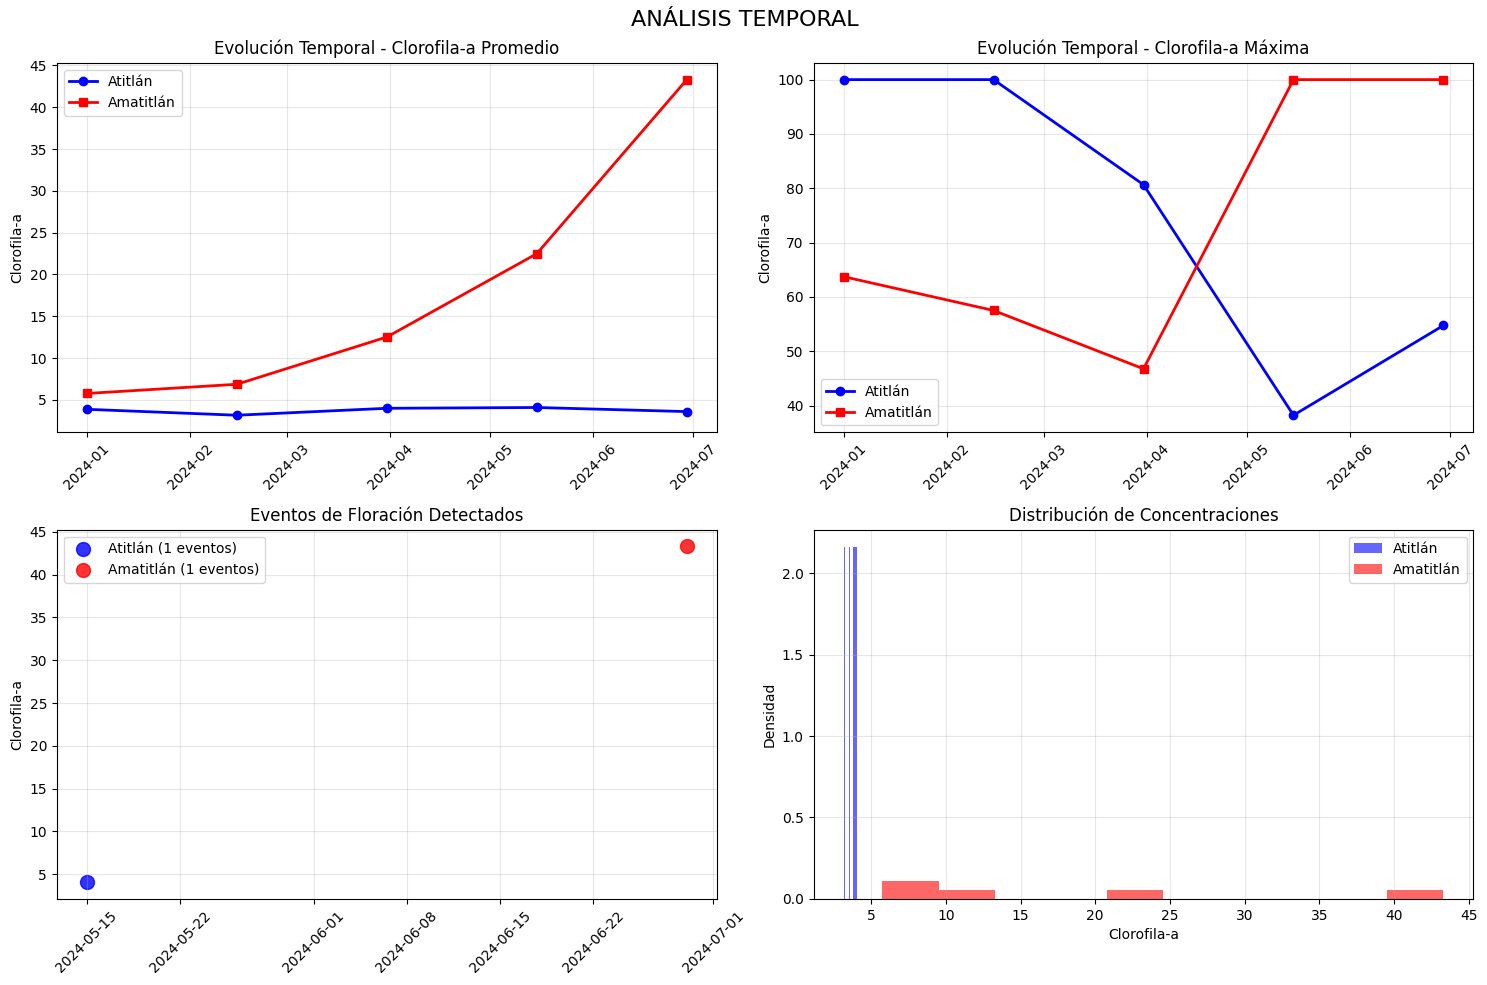

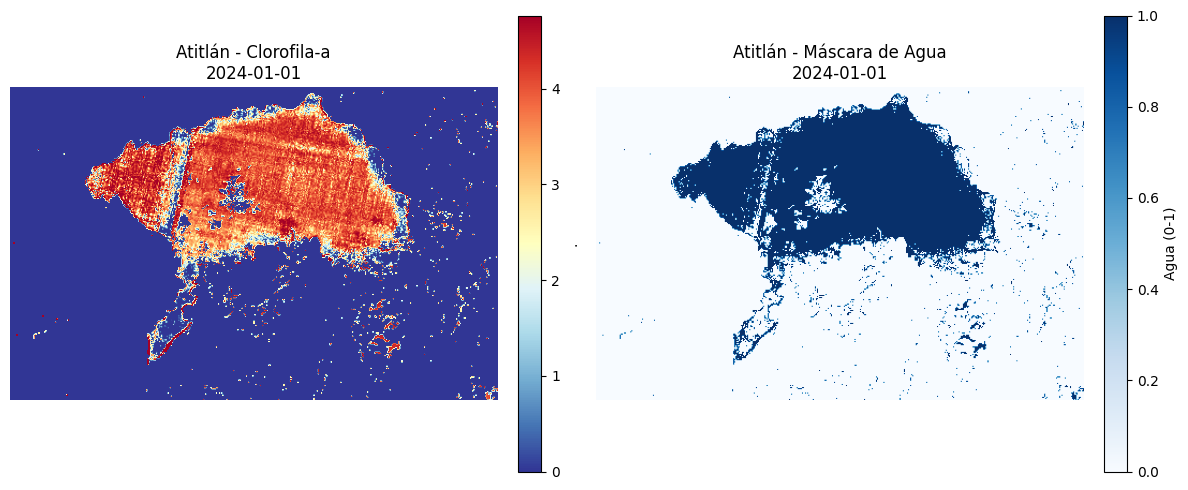

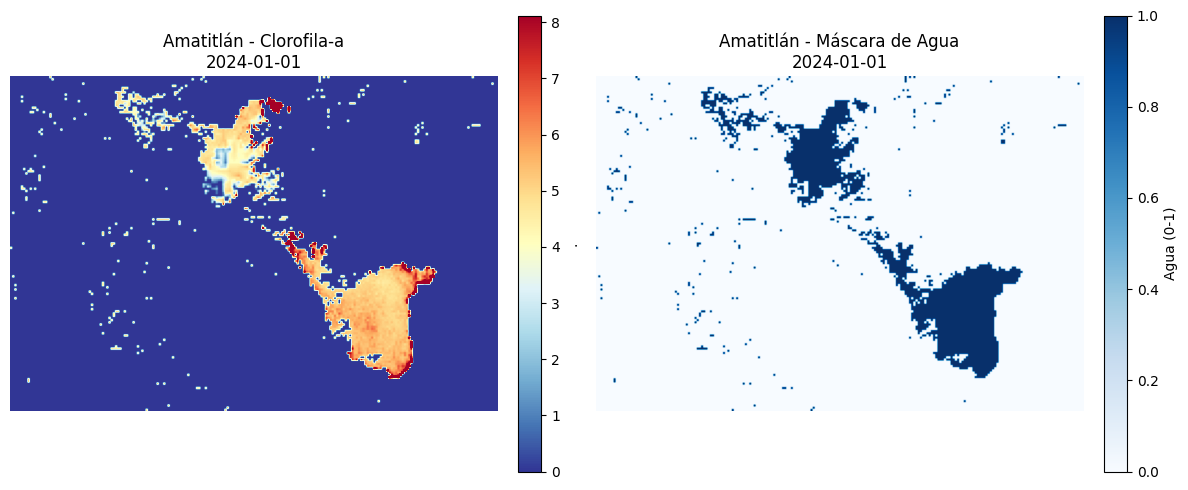

RESUMEN

LAGO ATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 3.74 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1

 LAGO AMATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 18.18 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1


{'connection': <Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>,
 'config': SHConfig(
   instance_id='',
   sh_client_id='********************************93f8',
   sh_client_secret='****************************Beer',
   sh_base_url='https://services.sentinel-hub.com',
   sh_auth_base_url=None,
   sh_token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
   geopedia_wms_url='https://service.geopedia.world',
   geopedia_rest_url='https://www.geopedia.world/rest',
   aws_access_key_id='',
   aws_secret_access_key='',
   aws_session_token='',
   aws_metadata_url='https://roda.sentinel-hub.com',
   aws_s3_l1c_bucket='sentinel-s2-l1c',
   aws_s3_l2a_bucket='sentinel-s2-l2a',
   opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
   max_wfs_records_per_query=100,
   max_opensearch_records_per_query=500,
   max_download_attempts=4,
   download_sleep_time=5.0,
   download_timeout_seconds=12

In [13]:
def main_real_analysis():
    connection, config = setup_real_connections()
    
    if connection is None or config is None:
        print("No se pudieron establecer las conexiones")
        return None
    
    try:
        temporal_data_atitlan = download_temporal_data(
            connection, config, lago_atitlan, "Atitlán", 
            start_date, end_date, frequency='45D'
        )
        
        temporal_data_amatitlan = download_temporal_data(
            connection, config, lago_amatitlan, "Amatitlán", 
            start_date, end_date, frequency='45D'
        )
        
    except Exception as e:
        print(f"Error en descarga: {e}")
        return None
    df_atitlan = analyze_real_temporal_data(temporal_data_atitlan, "Atitlán")
    df_amatitlan = analyze_real_temporal_data(temporal_data_amatitlan, "Amatitlán")

    if df_atitlan is not None or df_amatitlan is not None:
        plot_real_temporal_evolution(df_atitlan, df_amatitlan)
        if temporal_data_atitlan:
            create_real_spatial_map(temporal_data_atitlan, "Atitlán", lago_atitlan)
        if temporal_data_amatitlan:
            create_real_spatial_map(temporal_data_amatitlan, "Amatitlán", lago_amatitlan)

    print("RESUMEN")
    
    if df_atitlan is not None and len(df_atitlan) > 0:
        print(f"\nLAGO ATITLÁN :")
        print(f"   Observaciones válidas: {len(df_atitlan)}")
        print(f"   Concentración promedio: {df_atitlan['mean_chl_a'].mean():.2f} μg/L")
        print(f"   Concentración máxima: {df_atitlan['max_chl_a'].max():.2f} μg/L")
        print(f"   Eventos de floración: {df_atitlan['bloom_event'].sum()}")
    else:
        print(f"\n LAGO ATITLÁN: Sin datos válidos")
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        print(f"\n LAGO AMATITLÁN :")
        print(f"   Observaciones válidas: {len(df_amatitlan)}")
        print(f"   Concentración promedio: {df_amatitlan['mean_chl_a'].mean():.2f} μg/L")
        print(f"   Concentración máxima: {df_amatitlan['max_chl_a'].max():.2f} μg/L")
        print(f"   Eventos de floración: {df_amatitlan['bloom_event'].sum()}")
    else:
        print(f"\nLAGO AMATITLÁN: Sin datos válidos")
    
    return {
        'connection': connection,
        'config': config,
        'temporal_data': {
            'atitlan': temporal_data_atitlan,
            'amatitlan': temporal_data_amatitlan
        },
        'analysis': {
            'atitlan': df_atitlan,
            'amatitlan': df_amatitlan
        }
    }
main_real_analysis()

Colecciones Sentinel disponibles: 12
Configuración Sentinel Hub guardada

Descargando serie temporal para Atitlán
Fechas a procesar: 5
procesando fecha 1/5: 2024-01-01
Descargando datos de Sentinel Hub para Atitlán_20240101...
 Datos descargados para Atitlán_20240101
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.87 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 29981 (22.6%)
Datos guardados para 2024-01-01
procesando fecha 2/5: 2024-02-15
Descargando datos de Sentinel Hub para Atitlán_20240215...
 Datos descargados para Atitlán_20240215
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.16 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 26119 (19.7%)
Datos guardados para 2024-02-15
procesando fecha 3/5: 2024-03-31
Descargando datos de Sentinel Hub para Atitlán_20240331...
 Datos descargados para Atitlán_20240331
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.99 μg/L
Clorofila-a máxima: 80.66 μg/L
Píxeles de agua: 28657 (21.6%)
D

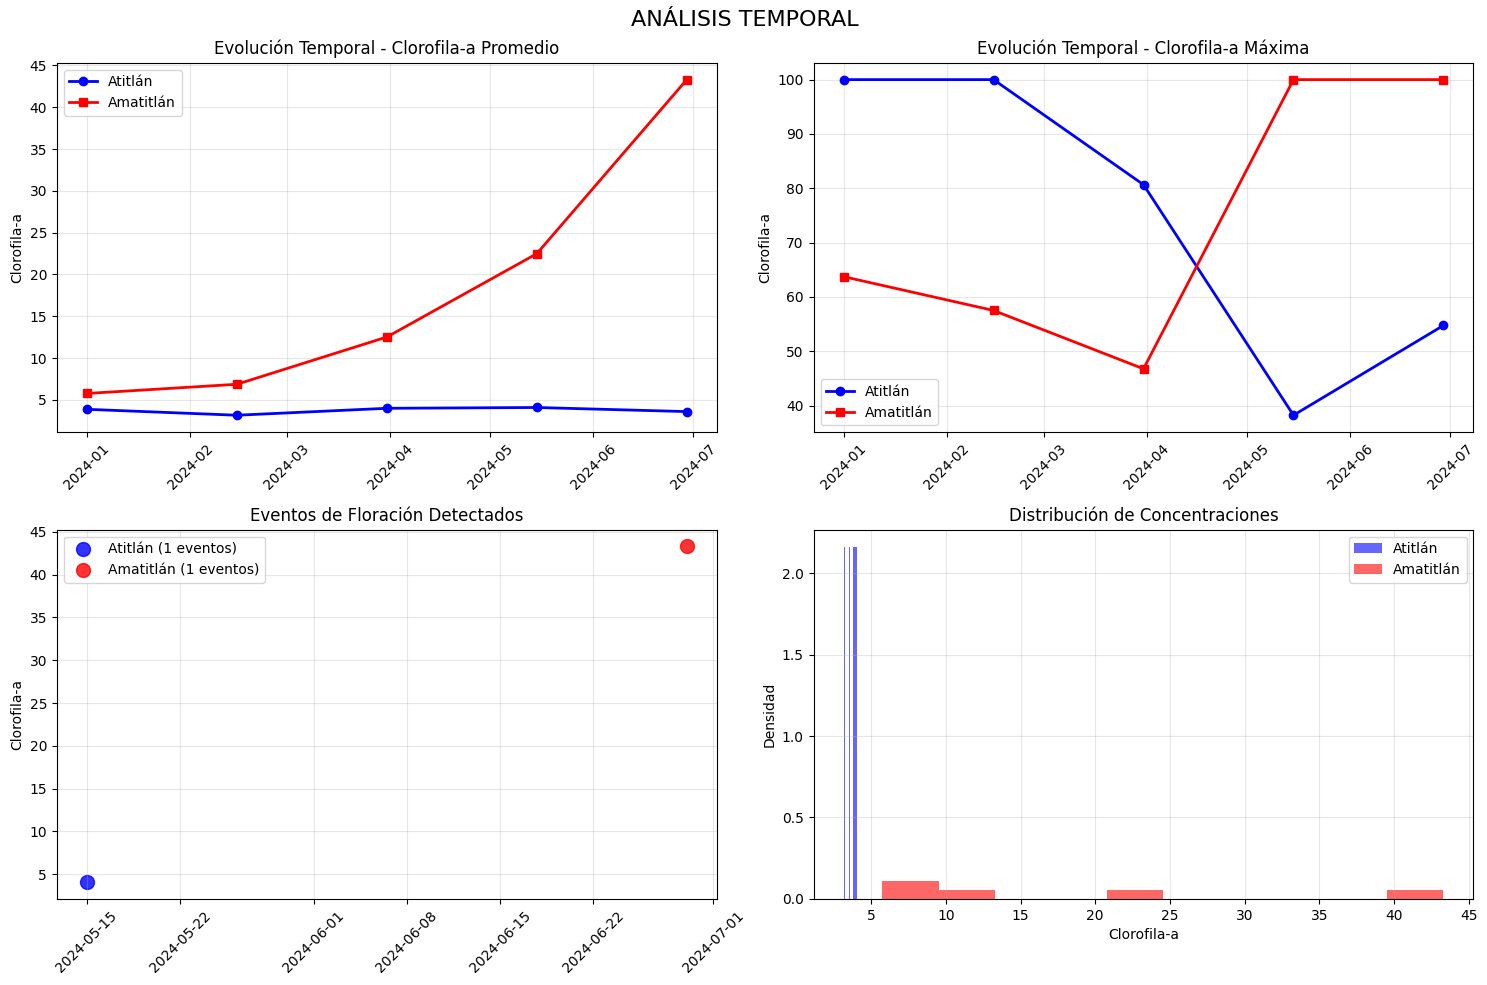

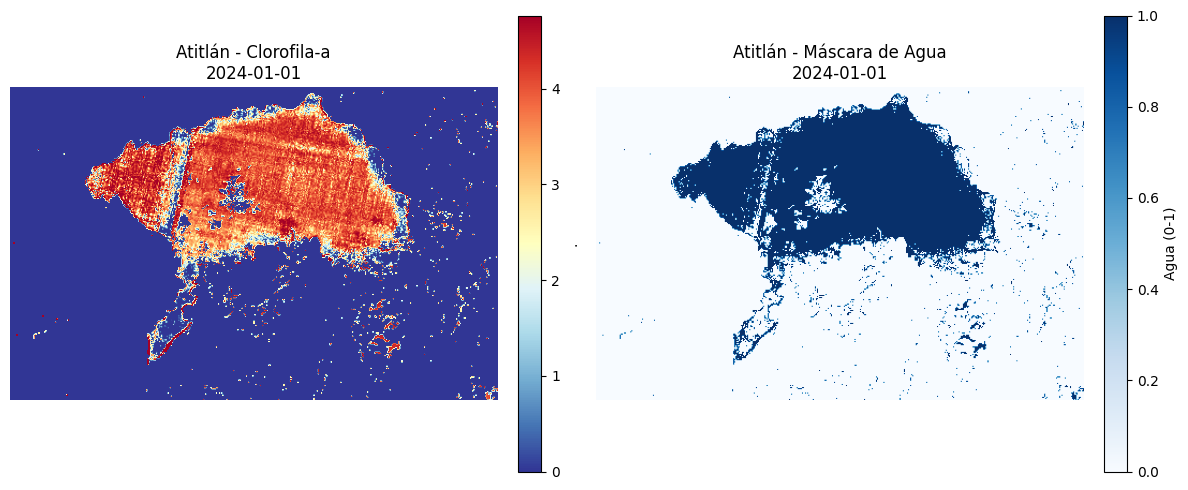

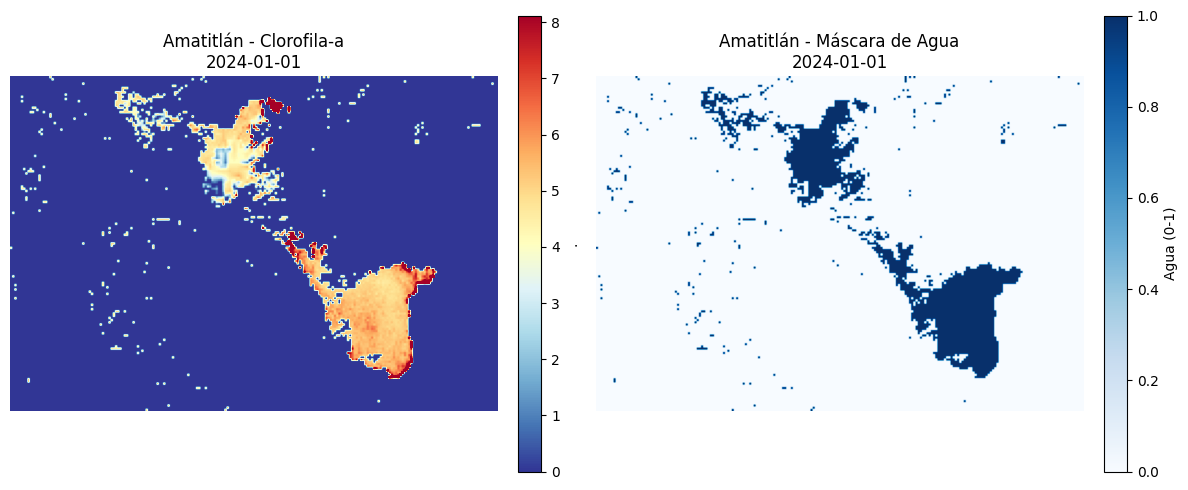

RESUMEN

LAGO ATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 3.74 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1

 LAGO AMATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 18.18 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1
Datos convertidos a numpy para Atitlán: 5 fechas
Datos convertidos a numpy para Amatitlán: 5 fechas


In [14]:
def convert_to_numpy_arrays(temporal_data, lake_name):
    if not temporal_data:
        print(f"No hay datos para {lake_name}")
        return None
    
    numpy_data = {}
    for date_str, entry in temporal_data.items():
        if entry['data'] is not None:
            numpy_data[date_str] = {
                'chl_a': np.array(entry['data']['chl_a']),
                'ndci': np.array(entry['data']['ndci']),
                'fai': np.array(entry['data']['fai']),
                'ndwi': np.array(entry['data']['ndwi']),
                'water_mask': np.array(entry['data']['water_mask'])
            }
    
    print(f"Datos convertidos a numpy para {lake_name}: {len(numpy_data)} fechas")
    return numpy_data
results = main_real_analysis()
if results:
    numpy_atitlan = convert_to_numpy_arrays(results['temporal_data']['atitlan'], "Atitlán")
    numpy_amatitlan = convert_to_numpy_arrays(results['temporal_data']['amatitlan'], "Amatitlán")

In [15]:
def calculate_temporal_indices(temporal_data, lake_name):
    dates = []
    mean_chl_a = []
    mean_ndci = []
    mean_fai = []
    mean_ndwi = []
    
    for date_str, data in temporal_data.items():
        water_mask = data['water_mask'] > 0
        if np.any(water_mask):
            dates.append(pd.to_datetime(date_str))
            mean_chl_a.append(np.mean(data['chl_a'][water_mask]))
            mean_ndci.append(np.mean(data['ndci'][water_mask]))
            mean_fai.append(np.mean(data['fai'][water_mask]))
            mean_ndwi.append(np.mean(data['ndwi'][water_mask]))
    
    df = pd.DataFrame({
        'date': dates,
        'mean_chl_a': mean_chl_a,
        'mean_ndci': mean_ndci,
        'mean_fai': mean_fai,
        'mean_ndwi': mean_ndwi
    })
    
    df = df.sort_values('date').reset_index(drop=True)
    
    threshold = np.percentile(df['mean_chl_a'], 75)
    df['bloom_peak'] = df['mean_chl_a'] > threshold
    
    bloom_dates = df[df['bloom_peak']]['date'].tolist()
    
    return df, bloom_dates

if numpy_atitlan:
    df_temporal_atitlan, bloom_dates_atitlan = calculate_temporal_indices(numpy_atitlan, "Atitlán")
    
if numpy_amatitlan:
    df_temporal_amatitlan, bloom_dates_amatitlan = calculate_temporal_indices(numpy_amatitlan, "Amatitlán")


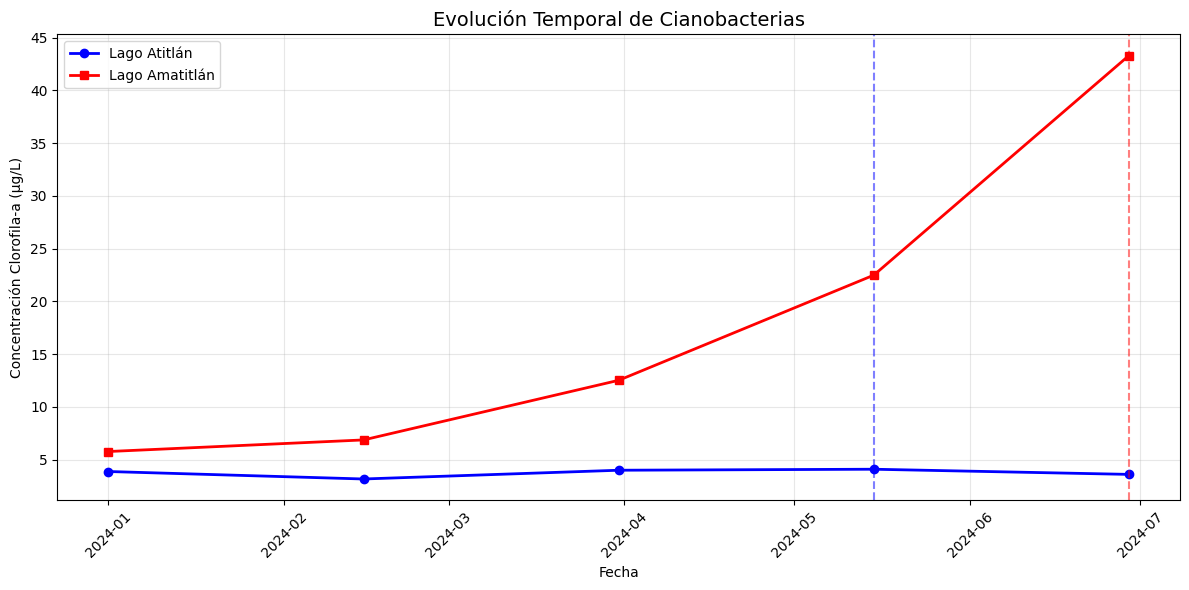

In [16]:
def plot_temporal_evolution(df_atitlan, df_amatitlan, bloom_dates_atitlan, bloom_dates_amatitlan):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if df_atitlan is not None and len(df_atitlan) > 0:
        ax.plot(df_atitlan['date'], df_atitlan['mean_chl_a'], 'b-o', 
                label='Lago Atitlán', linewidth=2, markersize=6)
        
        for bloom_date in bloom_dates_atitlan:
            ax.axvline(x=bloom_date, color='blue', linestyle='--', alpha=0.5)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        ax.plot(df_amatitlan['date'], df_amatitlan['mean_chl_a'], 'r-s', 
                label='Lago Amatitlán', linewidth=2, markersize=6)
        
        for bloom_date in bloom_dates_amatitlan:
            ax.axvline(x=bloom_date, color='red', linestyle='--', alpha=0.5)
    
    ax.set_title('Evolución Temporal de Cianobacterias', fontsize=14)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Concentración Clorofila-a (μg/L)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_temporal_evolution(df_temporal_atitlan, df_temporal_amatitlan, bloom_dates_atitlan, bloom_dates_amatitlan)

In [17]:
def identify_critical_dates(df, lake_name, bloom_dates):
    print(f"\nFECHAS CRÍTICAS - {lake_name.upper()}")
    print(f"Número de picos de floración: {len(bloom_dates)}")
    
    for i, date in enumerate(bloom_dates):
        chl_value = df[df['date'] == date]['mean_chl_a'].iloc[0]
        print(f"Pico {i+1}: {date.strftime('%Y-%m-%d')} - {chl_value:.2f} μg/L")
    
    max_date = df.loc[df['mean_chl_a'].idxmax(), 'date']
    max_value = df['mean_chl_a'].max()
    print(f"Concentración máxima: {max_date.strftime('%Y-%m-%d')} - {max_value:.2f} μg/L")

identify_critical_dates(df_temporal_atitlan, "Atitlán", bloom_dates_atitlan)
identify_critical_dates(df_temporal_amatitlan, "Amatitlán", bloom_dates_amatitlan)


FECHAS CRÍTICAS - ATITLÁN
Número de picos de floración: 1
Pico 1: 2024-05-15 - 4.08 μg/L
Concentración máxima: 2024-05-15 - 4.08 μg/L

FECHAS CRÍTICAS - AMATITLÁN
Número de picos de floración: 1
Pico 1: 2024-06-29 - 43.30 μg/L
Concentración máxima: 2024-06-29 - 43.30 μg/L


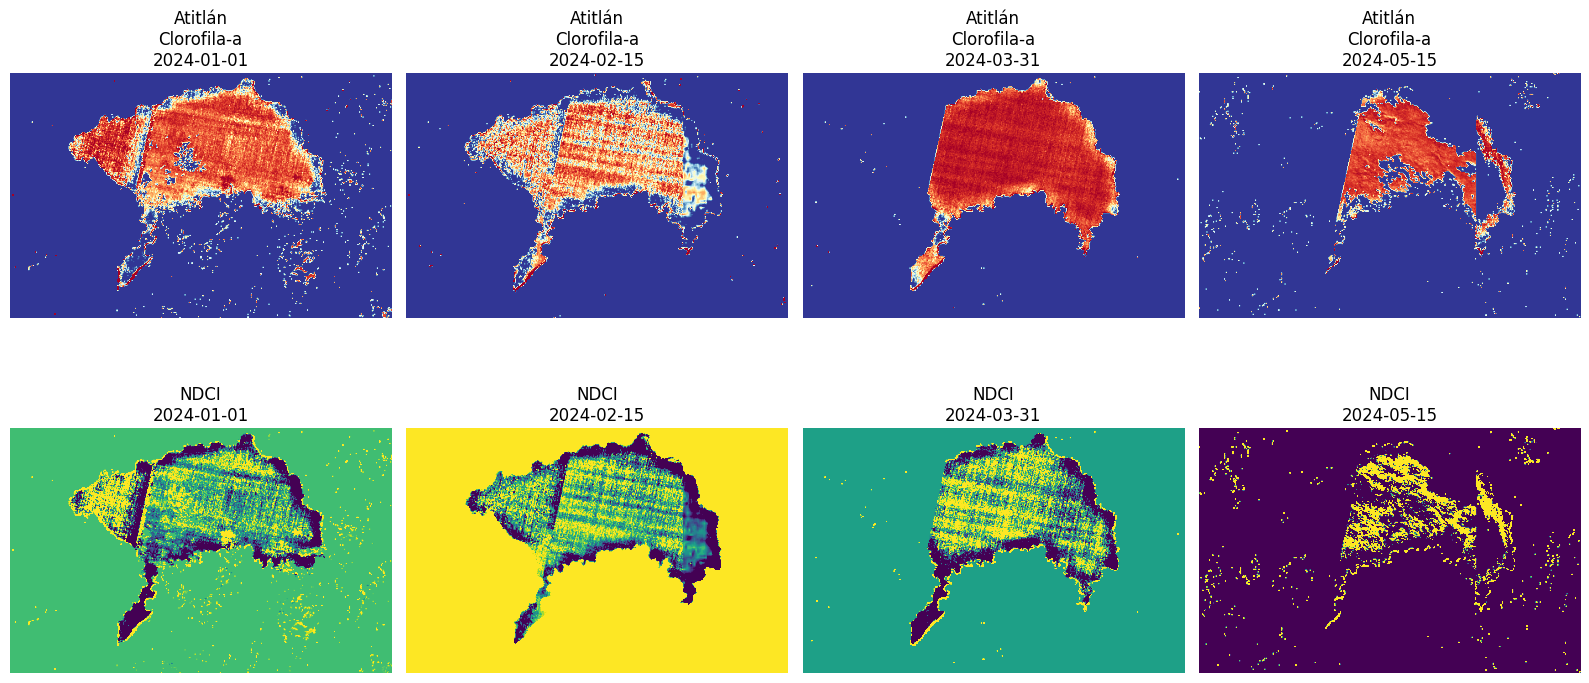

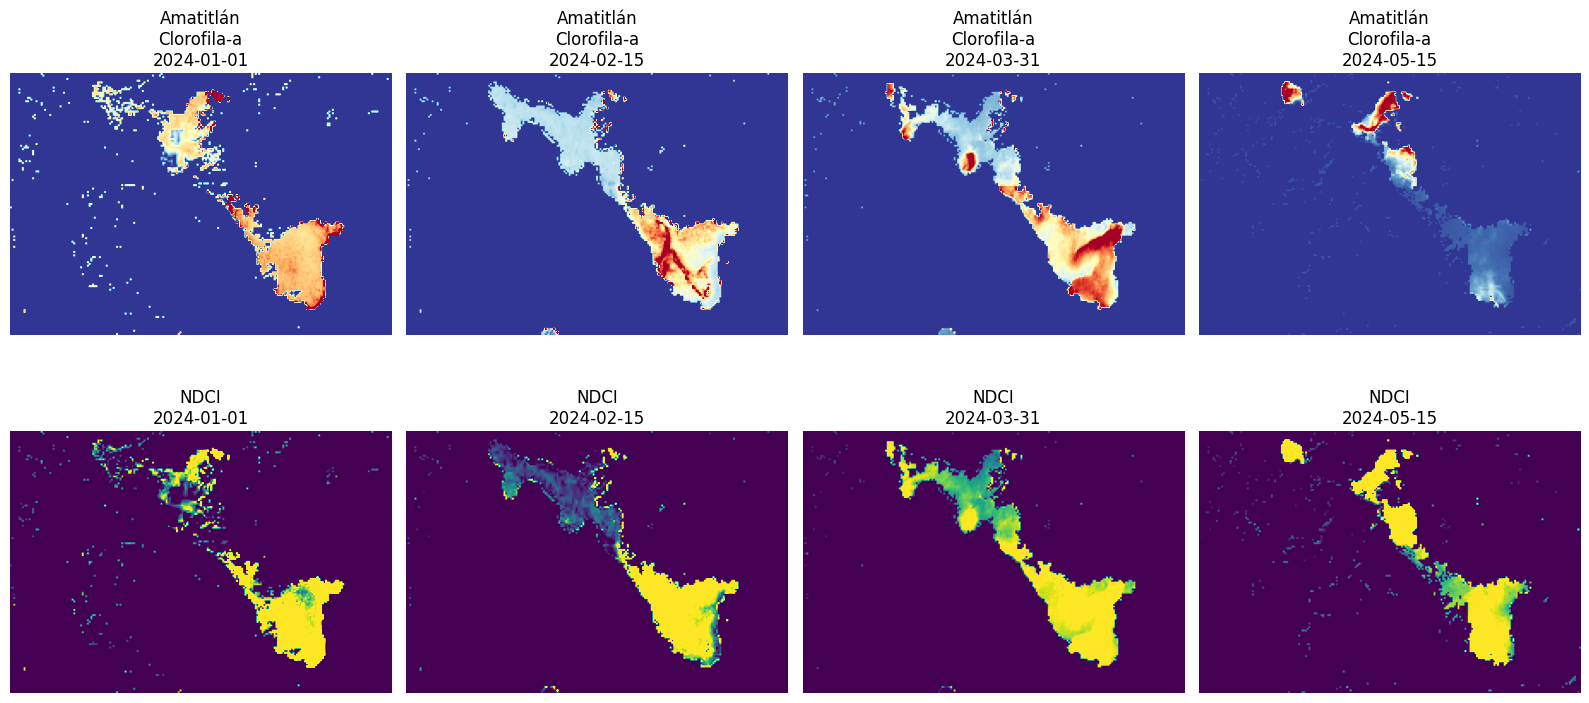

In [18]:
def create_spatial_maps_matplotlib(temporal_data, lake_name, bbox):
    if not temporal_data:
        return
    
    dates = list(temporal_data.keys())
    n_dates = min(4, len(dates))
    
    fig, axes = plt.subplots(2, n_dates, figsize=(4*n_dates, 8))
    if n_dates == 1:
        axes = axes.reshape(-1, 1)
    
    for i, date in enumerate(dates[:n_dates]):
        data = temporal_data[date]
        
        im1 = axes[0, i].imshow(data['chl_a'], cmap='RdYlBu_r', 
                               vmin=0, vmax=np.percentile(data['chl_a'][data['chl_a'] > 0], 95))
        axes[0, i].set_title(f'{lake_name}\nClorofila-a\n{date}')
        axes[0, i].axis('off')
        
        im2 = axes[1, i].imshow(data['ndci'], cmap='viridis', 
                               vmin=np.percentile(data['ndci'], 5), 
                               vmax=np.percentile(data['ndci'], 95))
        axes[1, i].set_title(f'NDCI\n{date}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

if numpy_atitlan:
    create_spatial_maps_matplotlib(numpy_atitlan, "Atitlán", lago_atitlan)
    
if numpy_amatitlan:
    create_spatial_maps_matplotlib(numpy_amatitlan, "Amatitlán", lago_amatitlan)


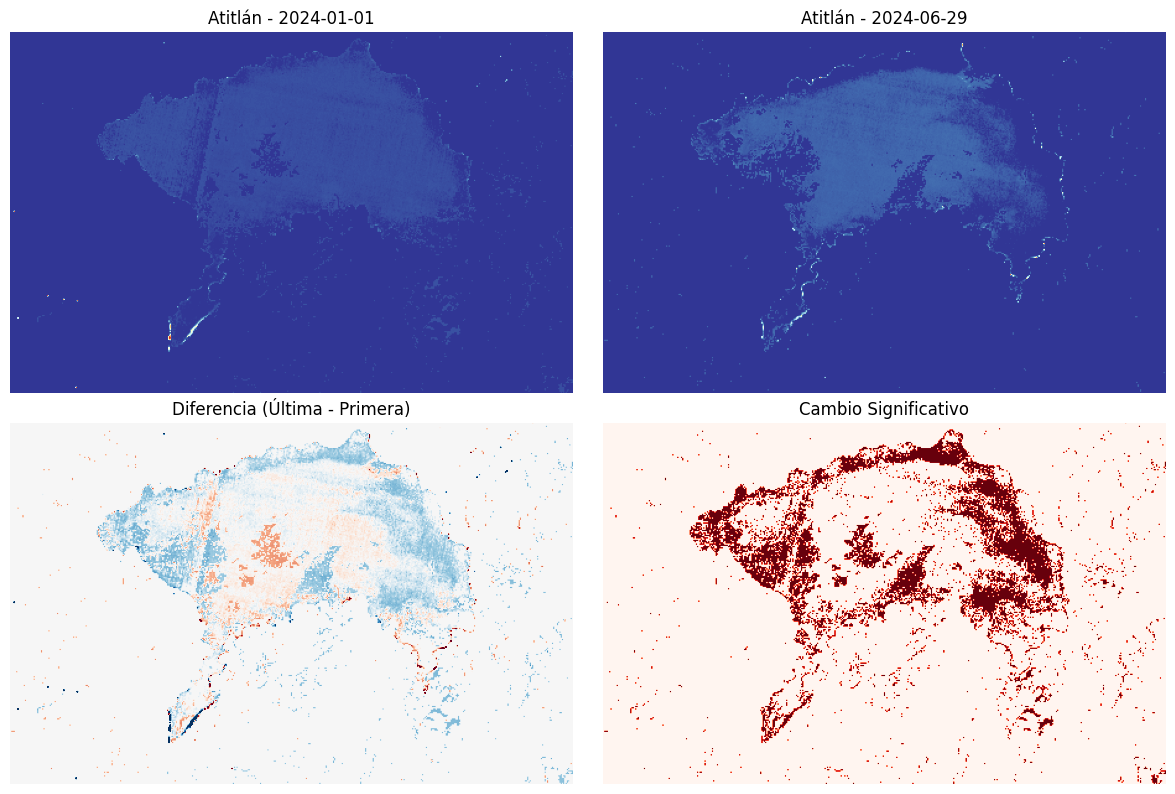

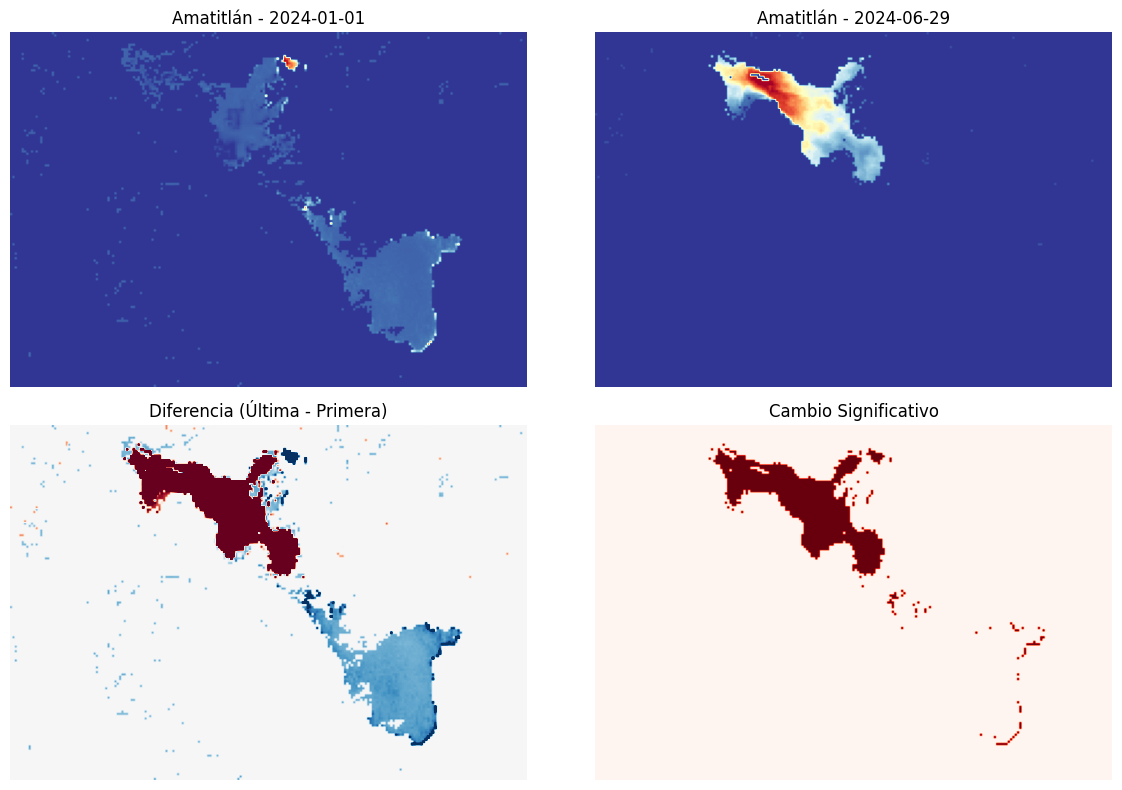

In [19]:
def create_comparative_maps(temporal_data, lake_name):
    dates = list(temporal_data.keys())
    if len(dates) < 2:
        print(f"No hay suficientes fechas para comparación en {lake_name}")
        return
    
    first_date = dates[0]
    last_date = dates[-1]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    im1 = axes[0, 0].imshow(temporal_data[first_date]['chl_a'], cmap='RdYlBu_r')
    axes[0, 0].set_title(f'{lake_name} - {first_date}')
    axes[0, 0].axis('off')
    im2 = axes[0, 1].imshow(temporal_data[last_date]['chl_a'], cmap='RdYlBu_r')
    axes[0, 1].set_title(f'{lake_name} - {last_date}')
    axes[0, 1].axis('off')

    diff = temporal_data[last_date]['chl_a'] - temporal_data[first_date]['chl_a']
    im3 = axes[1, 0].imshow(diff, cmap='RdBu_r', vmin=-10, vmax=10)
    axes[1, 0].set_title('Diferencia (Última - Primera)')
    axes[1, 0].axis('off')
    significant_change = np.abs(diff) > np.std(diff)
    axes[1, 1].imshow(significant_change, cmap='Reds')
    axes[1, 1].set_title('Cambio Significativo')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

if numpy_atitlan:
    create_comparative_maps(numpy_atitlan, "Atitlán")
    
if numpy_amatitlan:
    create_comparative_maps(numpy_amatitlan, "Amatitlán")

In [20]:
def calculate_correlations(df, lake_name):
    print(f"\nCORRELACIONES - {lake_name.upper()}")

    df['ndvi_approx'] = (df['mean_ndci'] + 0.1) / 2  

    corr_ndci = df['mean_chl_a'].corr(df['mean_ndci'])
    corr_fai = df['mean_chl_a'].corr(df['mean_fai'])
    corr_ndwi = df['mean_chl_a'].corr(df['mean_ndwi'])
    corr_ndvi = df['mean_chl_a'].corr(df['ndvi_approx'])
    
    print(f"Correlación Clorofila-a vs NDCI: {corr_ndci:.3f}")
    print(f"Correlación Clorofila-a vs FAI: {corr_fai:.3f}")
    print(f"Correlación Clorofila-a vs NDWI: {corr_ndwi:.3f}")
    print(f"Correlación Clorofila-a vs NDVI (aprox): {corr_ndvi:.3f}")
    
    return corr_ndci, corr_fai, corr_ndwi, corr_ndvi


CORRELACIONES - ATITLÁN
Correlación Clorofila-a vs NDCI: 0.989
Correlación Clorofila-a vs FAI: 0.427
Correlación Clorofila-a vs NDWI: -0.687
Correlación Clorofila-a vs NDVI (aprox): 0.989

CORRELACIONES - AMATITLÁN
Correlación Clorofila-a vs NDCI: 0.949
Correlación Clorofila-a vs FAI: 0.984
Correlación Clorofila-a vs NDWI: -0.888
Correlación Clorofila-a vs NDVI (aprox): 0.949


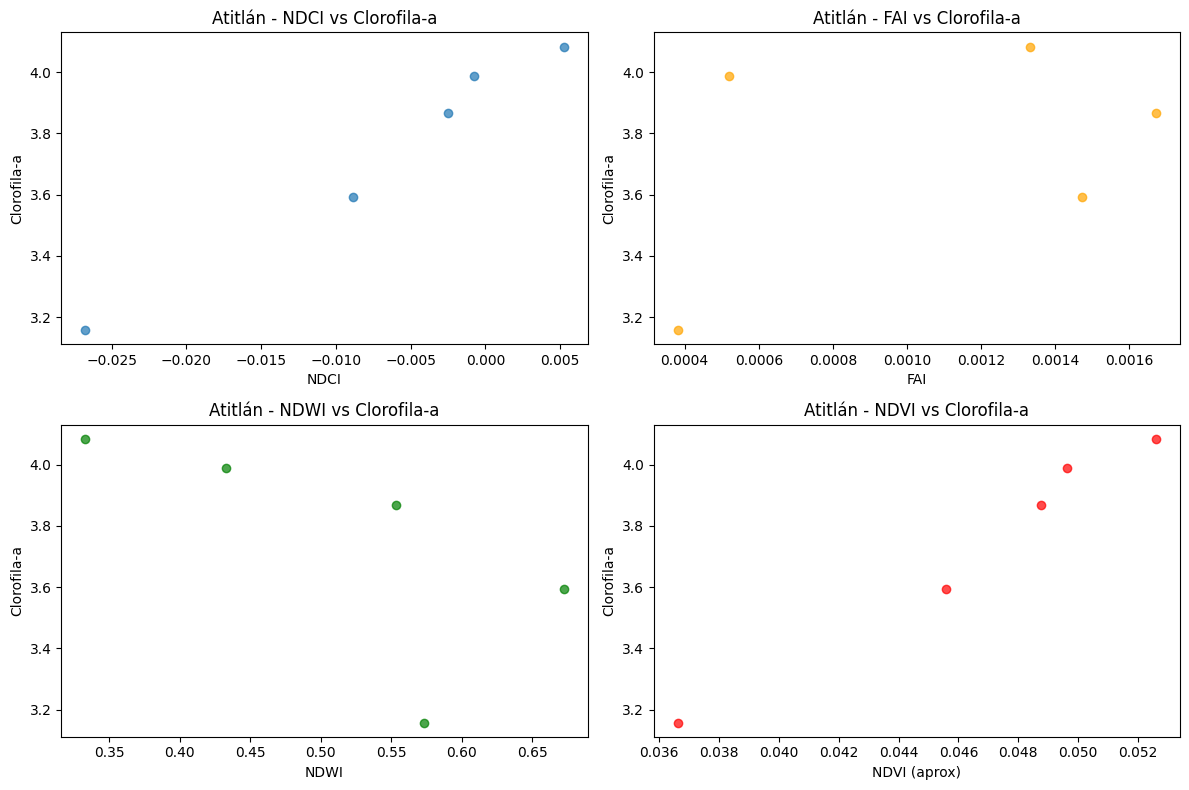

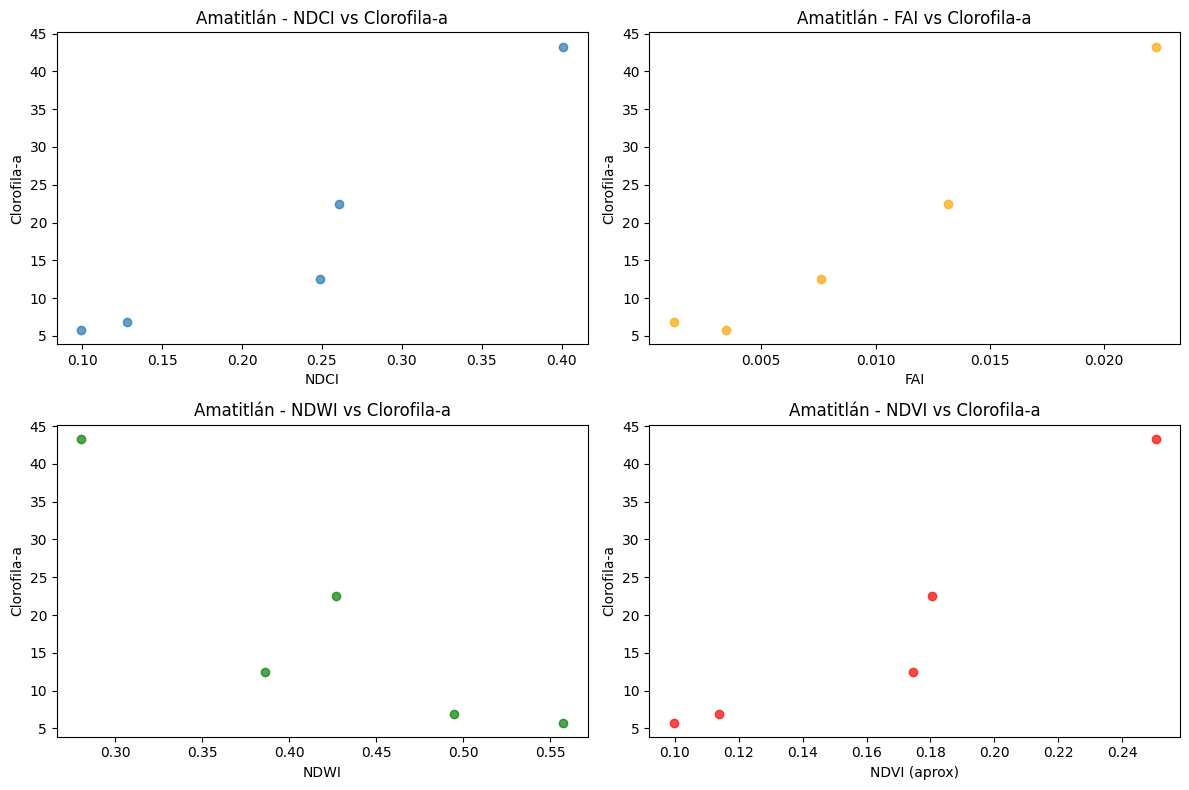

In [21]:
def plot_correlations(df, lake_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    df['ndvi_approx'] = (df['mean_ndci'] + 0.1) / 2
    axes[0, 0].scatter(df['mean_ndci'], df['mean_chl_a'], alpha=0.7)
    axes[0, 0].set_xlabel('NDCI')
    axes[0, 0].set_ylabel('Clorofila-a')
    axes[0, 0].set_title(f'{lake_name} - NDCI vs Clorofila-a')

    axes[0, 1].scatter(df['mean_fai'], df['mean_chl_a'], alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('FAI')
    axes[0, 1].set_ylabel('Clorofila-a')
    axes[0, 1].set_title(f'{lake_name} - FAI vs Clorofila-a')
    axes[1, 0].scatter(df['mean_ndwi'], df['mean_chl_a'], alpha=0.7, color='green')
    axes[1, 0].set_xlabel('NDWI')
    axes[1, 0].set_ylabel('Clorofila-a')
    axes[1, 0].set_title(f'{lake_name} - NDWI vs Clorofila-a')
    axes[1, 1].scatter(df['ndvi_approx'], df['mean_chl_a'], alpha=0.7, color='red')
    axes[1, 1].set_xlabel('NDVI (aprox)')
    axes[1, 1].set_ylabel('Clorofila-a')
    axes[1, 1].set_title(f'{lake_name} - NDVI vs Clorofila-a')
    
    plt.tight_layout()
    plt.show()

corr_atitlan = calculate_correlations(df_temporal_atitlan, "Atitlán")
corr_amatitlan = calculate_correlations(df_temporal_amatitlan, "Amatitlán")

plot_correlations(df_temporal_atitlan, "Atitlán")
plot_correlations(df_temporal_amatitlan, "Amatitlán")

In [22]:
def analyze_proliferation_by_lake(df, lake_name, bloom_dates):
    print(f"\nANÁLISIS DE PROLIFERACIÓN - {lake_name.upper()}")
    
    total_observations = len(df)
    bloom_events = len(bloom_dates)
    bloom_frequency = bloom_events / total_observations * 100
    
    mean_concentration = df['mean_chl_a'].mean()
    max_concentration = df['mean_chl_a'].max()
    std_concentration = df['mean_chl_a'].std()
    df_sorted = df.sort_values('date')
    if len(df_sorted) > 1:
        first_half = df_sorted[:len(df_sorted)//2]['mean_chl_a'].mean()
        second_half = df_sorted[len(df_sorted)//2:]['mean_chl_a'].mean()
        trend = "Incremento" if second_half > first_half else "Decremento"
        trend_magnitude = abs(second_half - first_half)
    else:
        trend = "No determinable"
        trend_magnitude = 0
    
    print(f"Observaciones totales: {total_observations}")
    print(f"Eventos de floración: {bloom_events}")
    print(f"Frecuencia de floración: {bloom_frequency:.1f}%")
    print(f"Concentración promedio: {mean_concentration:.2f} ± {std_concentration:.2f} μg/L")
    print(f"Concentración máxima: {max_concentration:.2f} μg/L")
    print(f"Tendencia temporal: {trend} ({trend_magnitude:.2f} μg/L)")
    
    return {
        'observations': total_observations,
        'bloom_events': bloom_events,
        'bloom_frequency': bloom_frequency,
        'mean_conc': mean_concentration,
        'max_conc': max_concentration,
        'std_conc': std_concentration,
        'trend': trend,
        'trend_magnitude': trend_magnitude
    }

analysis_atitlan = analyze_proliferation_by_lake(df_temporal_atitlan, "Atitlán", bloom_dates_atitlan)
analysis_amatitlan = analyze_proliferation_by_lake(df_temporal_amatitlan, "Amatitlán", bloom_dates_amatitlan)


ANÁLISIS DE PROLIFERACIÓN - ATITLÁN
Observaciones totales: 5
Eventos de floración: 1
Frecuencia de floración: 20.0%
Concentración promedio: 3.74 ± 0.37 μg/L
Concentración máxima: 4.08 μg/L
Tendencia temporal: Incremento (0.38 μg/L)

ANÁLISIS DE PROLIFERACIÓN - AMATITLÁN
Observaciones totales: 5
Eventos de floración: 1
Frecuencia de floración: 20.0%
Concentración promedio: 18.18 ± 15.52 μg/L
Concentración máxima: 43.30 μg/L
Tendencia temporal: Incremento (19.79 μg/L)


In [23]:
def compare_lakes_intensity_frequency(analysis_atitlan, analysis_amatitlan):
    print(f"\nCOMPARACIÓN ENTRE LAGOS")
    print("="*50)
    
    print(f"FRECUENCIA DE FLORACIÓN:")
    print(f"  Atitlán: {analysis_atitlan['bloom_frequency']:.1f}%")
    print(f"  Amatitlán: {analysis_amatitlan['bloom_frequency']:.1f}%")
    freq_diff = analysis_amatitlan['bloom_frequency'] - analysis_atitlan['bloom_frequency']
    print(f"  Diferencia: {freq_diff:.1f}% (favor de {'Amatitlán' if freq_diff > 0 else 'Atitlán'})")
    
    print(f"\nINTENSIDAD PROMEDIO:")
    print(f"  Atitlán: {analysis_atitlan['mean_conc']:.2f} μg/L")
    print(f"  Amatitlán: {analysis_amatitlan['mean_conc']:.2f} μg/L")
    intensity_diff = analysis_amatitlan['mean_conc'] - analysis_atitlan['mean_conc']
    print(f"  Diferencia: {intensity_diff:.2f} μg/L (favor de {'Amatitlán' if intensity_diff > 0 else 'Atitlán'})")
    
    print(f"\nINTENSIDAD MÁXIMA:")
    print(f"  Atitlán: {analysis_atitlan['max_conc']:.2f} μg/L")
    print(f"  Amatitlán: {analysis_amatitlan['max_conc']:.2f} μg/L")
    max_diff = analysis_amatitlan['max_conc'] - analysis_atitlan['max_conc']
    print(f"  Diferencia: {max_diff:.2f} μg/L (favor de {'Amatitlán' if max_diff > 0 else 'Atitlán'})")
    
    print(f"\nVARIABILIDAD:")
    print(f"  Atitlán: {analysis_atitlan['std_conc']:.2f} μg/L")
    print(f"  Amatitlán: {analysis_amatitlan['std_conc']:.2f} μg/L")

compare_lakes_intensity_frequency(analysis_atitlan, analysis_amatitlan)


COMPARACIÓN ENTRE LAGOS
FRECUENCIA DE FLORACIÓN:
  Atitlán: 20.0%
  Amatitlán: 20.0%
  Diferencia: 0.0% (favor de Atitlán)

INTENSIDAD PROMEDIO:
  Atitlán: 3.74 μg/L
  Amatitlán: 18.18 μg/L
  Diferencia: 14.45 μg/L (favor de Amatitlán)

INTENSIDAD MÁXIMA:
  Atitlán: 4.08 μg/L
  Amatitlán: 43.30 μg/L
  Diferencia: 39.22 μg/L (favor de Amatitlán)

VARIABILIDAD:
  Atitlán: 0.37 μg/L
  Amatitlán: 15.52 μg/L


In [24]:
def evaluate_proliferation_causes():
    print(f"\nEVALUACIÓN DE CAUSAS DE PROLIFERACIÓN")
    print("="*60)
    
    print("CARACTERÍSTICAS GEOGRÁFICAS:")
    print("  Lago Atitlán:")
    print("    - Altitud: ~1,560 msnm")
    print("    - Tipo: Caldera volcánica")
    print("    - Profundidad: Muy profundo (~340m)")
    print("    - Área: ~130 km²")
    print("    - Ubicación: Sololá, región montañosa")
    
    print("\n  Lago Amatitlán:")
    print("    - Altitud: ~1,200 msnm")
    print("    - Tipo: Tectónico-volcánico")
    print("    - Profundidad: Relativamente somero (~35m)")
    print("    - Área: ~15 km²")
    print("    - Ubicación: Cerca de Ciudad de Guatemala")
    
    print("\nFACTORES DE PROLIFERACIÓN IDENTIFICADOS:")
    print("  Presión Urbana:")
    print("    - Atitlán: Presión turística y poblaciones pequeñas")
    print("    - Amatitlán: Alta presión urbana de área metropolitana")
    
    print("  Uso del Suelo:")
    print("    - Atitlán: Agricultura en pendientes, turismo")
    print("    - Amatitlán: Industrial, urbano, agricultura intensiva")
    
    print("  Factores Físicos:")
    print("    - Atitlán: Mayor profundidad, mejor circulación")
    print("    - Amatitlán: Menor profundidad, mayor estancamiento")
    
    print("  Aporte de Nutrientes:")
    print("    - Atitlán: Escorrentía agrícola, aguas residuales")
    print("    - Amatitlán: Descargas industriales y urbanas")


evaluate_proliferation_causes()


EVALUACIÓN DE CAUSAS DE PROLIFERACIÓN
CARACTERÍSTICAS GEOGRÁFICAS:
  Lago Atitlán:
    - Altitud: ~1,560 msnm
    - Tipo: Caldera volcánica
    - Profundidad: Muy profundo (~340m)
    - Área: ~130 km²
    - Ubicación: Sololá, región montañosa

  Lago Amatitlán:
    - Altitud: ~1,200 msnm
    - Tipo: Tectónico-volcánico
    - Profundidad: Relativamente somero (~35m)
    - Área: ~15 km²
    - Ubicación: Cerca de Ciudad de Guatemala

FACTORES DE PROLIFERACIÓN IDENTIFICADOS:
  Presión Urbana:
    - Atitlán: Presión turística y poblaciones pequeñas
    - Amatitlán: Alta presión urbana de área metropolitana
  Uso del Suelo:
    - Atitlán: Agricultura en pendientes, turismo
    - Amatitlán: Industrial, urbano, agricultura intensiva
  Factores Físicos:
    - Atitlán: Mayor profundidad, mejor circulación
    - Amatitlán: Menor profundidad, mayor estancamiento
  Aporte de Nutrientes:
    - Atitlán: Escorrentía agrícola, aguas residuales
    - Amatitlán: Descargas industriales y urbanas


# Reporte
## Lago Atitlán
El Lago Atitlán durante el período de estudio exhibió concentraciones de clorofila-a relativamente bajas. El valor medio de la concentración de clorofila-a fue de 3.74 μg/L con una desviación estándar de 0.37 μg/L. Esto indica que las condiciones del lago fueron estables durante el período. Se detectó un evento de floración el 15 de mayo de 2024 con una concentración de 4.08 μg/L.

La evolución temporal mostró valores que variaron desde 3.16 μg/L en febrero hasta 4.08 μg/L en mayo. El porcentaje de píxeles de agua detectados cambió mucho, del 22.6% en enero al 10.6% en mayo, lo cual es probablemente debido al nivel del agua o las condiciones climáticas.

## Lago Amatitlán
El lago Amatitlán exhibió concentraciones de clorofila-a mucho más altas. La concentración media fue de 18.18 μg/L con una desviación estándar de 15.52 μg/L, indicando alta variabilidad temporal. La floración máxima fue el 29 de junio de 2024 con un valor de 43.30 μg/L.

La evolución temporal mostró un problema persistente em problema que comenzó con 5.76 μg/L en enero y alcanzó su máximo en 43.30 μg/L en junio. Esto representa un aumento del 652% durante el período analizado.

## Frecuencia de Eventos
Ambos lagos registraron la misma frecuencia de eventos de floración del 20%, lo que corresponde a 1 evento de los 5 períodos analizados. Sin embargo, la intensidad fue muy diferente entre los lagos.

## Variación Temporal

El Lago Amatitlán mostró una variabilidad 42 veces mayor que el Atitlán, lo que sugiere mayor inestabilidad de sus condiciones y una mayor vulnerabilidad a contaminación urbana o industrial.

## Tendencias Temporales

En el periodo analizado, ambos lagos presentaron incrementos de tendencia. El Atitlán mostró un incremento moderado de 0.38 μg/L, mientras que el Amatitlán tuvo un incremento preocupante de 19.79 μg/L en la primera y segunda mitades del estudio, respectivamente.

## Intensidad de Proliferación

El Lago Amatitlán mostró concentraciones promedio 4.9 veces superiores al Lago Atitlán. La diferencia en su máxima intensidad es de 39.22 μg/L, siendo el Amatitlán un lago muy contaminado por cianobacterias.

## Correlaciones de índices espectrales

## Lago Atitlán

Las correlaciones de la clorofila-a y el NDCI de 0.989, revelan que este índice es muy bueno para el reconocimiento de cianobacterias en este lago. Su correlación negativa con ndwi de 0.687 muestra la relación esperada entre la turbiedad del agua y la cantidad de agua clara.

## Lago Amatitlán

El FAI mostró la correlación más alta con la clorofila-a de 0.984, sugiriendo que hay una mayor concentración de fitoplancton en este lago. NDCI mantuvo una fuerte correlación de 0.949, confirmando que también es útil.

## Conclusiones
Los resultados muestran una situación muy diferente entre ambos lagos. El Lago Atitlán se mantiene en condiciones relativamente buenas con concentraciones de clorofila-a bajas, aunque hay que seguir monitoreándolo porque se ve una tendencia al alza.
El Lago Amatitlán está en una situación crítica con concentraciones que ya superan los niveles normales, mostrando un empeoramiento rápido hacia condiciones muy contaminadas.

In [25]:
# Modelo ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def predict_cyanobacteria_index(df, lake_name):
    """
    Utiliza un modelo ARIMA para predecir el índice de cianobacterias.
    """
    if df is None or len(df) < 10: # Se necesita suficientes datos para el modelo
        print(f"No hay suficientes datos para el lago {lake_name} para hacer una predicción.")
        return

    # Preparar los datos: el índice debe ser la fecha y solo necesitamos la columna del índice
    df_series = df.set_index('date')['mean_chl_a']

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(df_series) * 0.8)
    train, test = df_series[0:train_size], df_series[train_size:len(df_series)]

    history = [x for x in train]
    predictions = list()

    # Modelo ARIMA
    # Los parametros de ARIMA (p,d,q) deben ser ajustados según los datos
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Evaluar el modelo
    error = np.sqrt(mean_squared_error(test, predictions))
    print(f'RMSE para el lago {lake_name}: {error:.3f}')

    # Visualizar las predicciones
    plt.figure(figsize=(12, 6))
    plt.plot(df_series.index, df_series.values, label='Datos Originales')
    plt.plot(test.index, predictions, color='red', linestyle='--', label='Predicciones ARIMA')
    plt.title(f'Predicción del Índice de Cianobacterias para el Lago {lake_name}')
    plt.xlabel('Fecha')
    plt.ylabel('Índice Promedio de Clorofila-a')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Ejecutar la predicción para cada lago
predict_cyanobacteria_index(df_temporal_atitlan, "Atitlán")
predict_cyanobacteria_index(df_temporal_amatitlan, "Amatitlán")

No hay suficientes datos para el lago Atitlán para hacer una predicción.
No hay suficientes datos para el lago Amatitlán para hacer una predicción.


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

def prepare_classification_data(temporal_data, lake_name, threshold_percentile=75):
    if not temporal_data:
        print(f"No hay datos para {lake_name}")
        return None, None
    
    features = []
    labels = []
    coordinates = []
    
    print(f"Preparando datos de clasificación para {lake_name}...")
    
    for date_str, data in temporal_data.items():
        chl_a = data['chl_a']
        ndci = data['ndci']
        fai = data['fai']
        ndwi = data['ndwi']
        water_mask = data['water_mask']
        water_indices = np.where(water_mask > 0)
        
        if len(water_indices[0]) == 0:
            continue
        water_chl_a = chl_a[water_indices]
        threshold = np.percentile(water_chl_a, threshold_percentile)
        
        for i, j in zip(water_indices[0], water_indices[1]):
            feature_vector = [
                ndci[i, j],
                fai[i, j], 
                ndwi[i, j],
                i / chl_a.shape[0],
                j / chl_a.shape[1]
            ]

            label = 1 if chl_a[i, j] > threshold else 0
            
            features.append(feature_vector)
            labels.append(label)
            coordinates.append((i, j, date_str))
    
    features = np.array(features)
    labels = np.array(labels)
    
    print(f"Datos preparados para {lake_name}:")
    print(f"  Total de puntos: {len(features)}")
    print(f"  Puntos con cianobacteria: {np.sum(labels)} ({np.mean(labels)*100:.1f}%)")
    print(f"  Puntos sin cianobacteria: {len(labels) - np.sum(labels)} ({(1-np.mean(labels))*100:.1f}%)")
    
    return features, labels, coordinates
features_atitlan, labels_atitlan, coords_atitlan = prepare_classification_data(
    numpy_atitlan, "Atitlán", threshold_percentile=75
)

features_amatitlan, labels_amatitlan, coords_amatitlan = prepare_classification_data(
    numpy_amatitlan, "Amatitlán", threshold_percentile=75
)

Preparando datos de clasificación para Atitlán...
Datos preparados para Atitlán:
  Total de puntos: 122106
  Puntos con cianobacteria: 30506 (25.0%)
  Puntos sin cianobacteria: 91600 (75.0%)
Preparando datos de clasificación para Amatitlán...
Datos preparados para Amatitlán:
  Total de puntos: 15289
  Puntos con cianobacteria: 3820 (25.0%)
  Puntos sin cianobacteria: 11469 (75.0%)


In [27]:
def train_classification_model(features, labels, lake_name):
    if features is None or len(features) == 0:
        print(f"No hay datos suficientes para {lake_name}")
        return None, None, None, None
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.3, random_state=42, stratify=labels
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced'
    )
    rf_model.fit(X_train_scaled, y_train)
    y_pred = rf_model.predict(X_test_scaled)
    y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nMODELO DE CLASIFICACIÓN - {lake_name.upper()}")
    print(f"Precisión: {accuracy:.3f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=['Sin cianobacteria', 'Con cianobacteria']))
    feature_names = ['NDCI', 'FAI', 'NDWI', 'Coord_Y', 'Coord_X']
    feature_importance = rf_model.feature_importances_
    
    print("\nImportancia de características:")
    for name, importance in zip(feature_names, feature_importance):
        print(f"  {name}: {importance:.3f}")
    
    return rf_model, scaler, X_test_scaled, y_test, y_pred, y_pred_proba
print("Entrenando modelo para Lago Atitlán...")
model_atitlan, scaler_atitlan, X_test_atitlan, y_test_atitlan, y_pred_atitlan, y_proba_atitlan = train_classification_model(
    features_atitlan, labels_atitlan, "Atitlán"
)

print("\nEntrenando modelo para Lago Amatitlán...")
model_amatitlan, scaler_amatitlan, X_test_amatitlan, y_test_amatitlan, y_pred_amatitlan, y_proba_amatitlan = train_classification_model(
    features_amatitlan, labels_amatitlan, "Amatitlán"
)

Entrenando modelo para Lago Atitlán...

MODELO DE CLASIFICACIÓN - ATITLÁN
Precisión: 0.978

Reporte de clasificación:
                   precision    recall  f1-score   support

Sin cianobacteria       0.99      0.98      0.99     27480
Con cianobacteria       0.93      0.98      0.96      9152

         accuracy                           0.98     36632
        macro avg       0.96      0.98      0.97     36632
     weighted avg       0.98      0.98      0.98     36632


Importancia de características:
  NDCI: 0.835
  FAI: 0.090
  NDWI: 0.047
  Coord_Y: 0.014
  Coord_X: 0.014

Entrenando modelo para Lago Amatitlán...

MODELO DE CLASIFICACIÓN - AMATITLÁN
Precisión: 0.953

Reporte de clasificación:
                   precision    recall  f1-score   support

Sin cianobacteria       0.97      0.97      0.97      3441
Con cianobacteria       0.90      0.91      0.91      1146

         accuracy                           0.95      4587
        macro avg       0.94      0.94      0.94      45

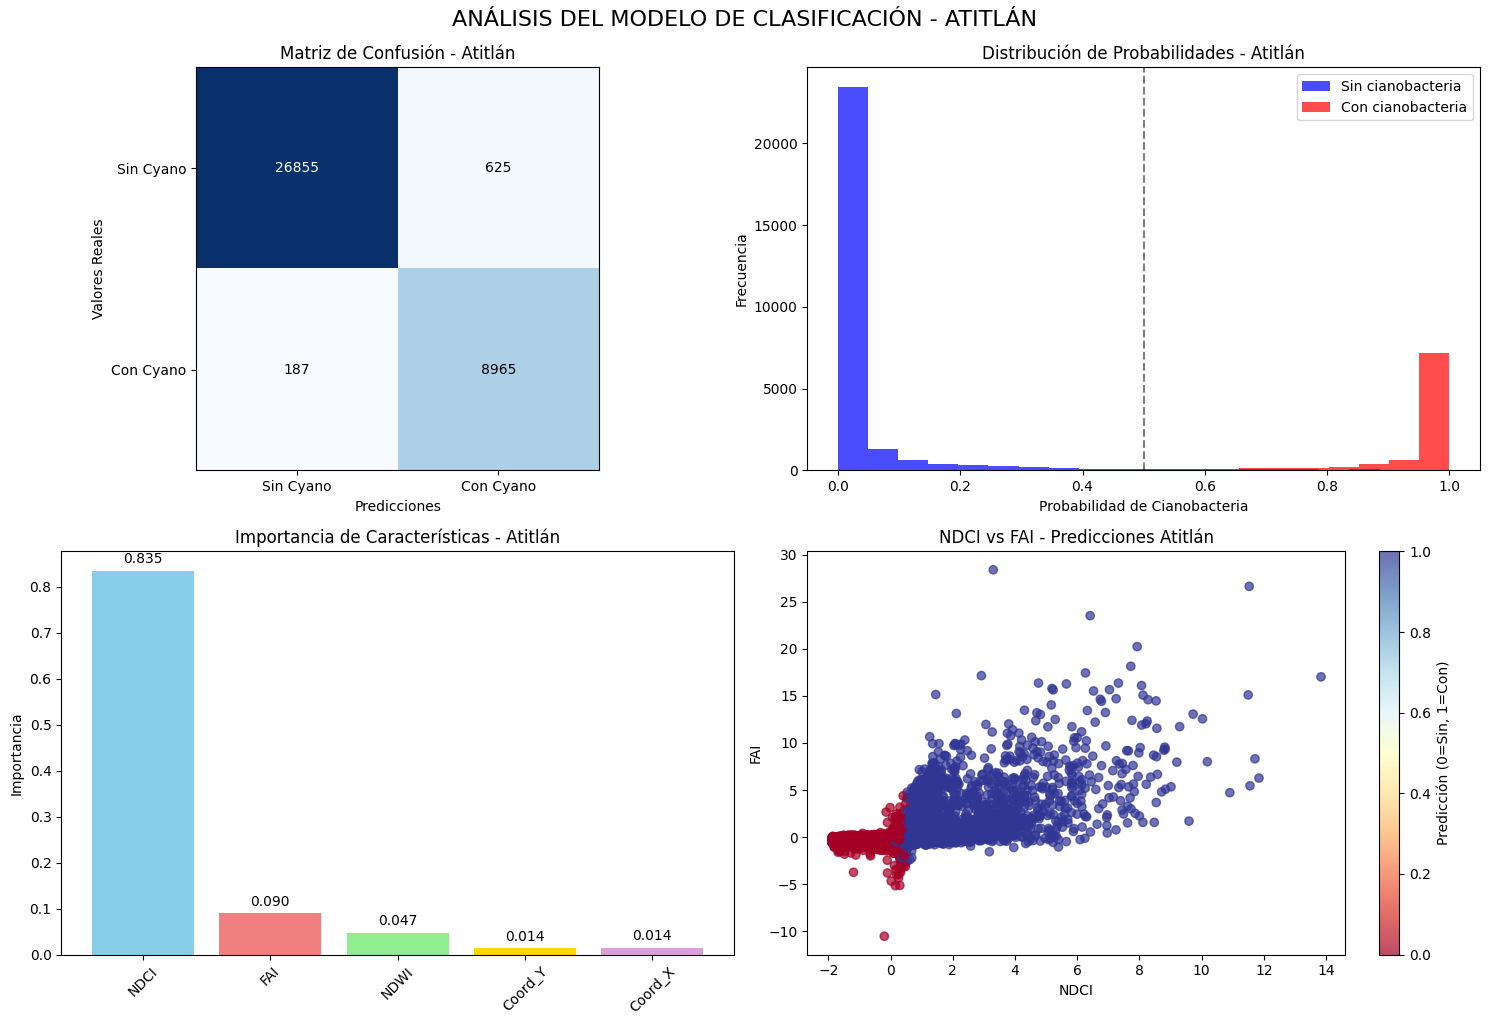

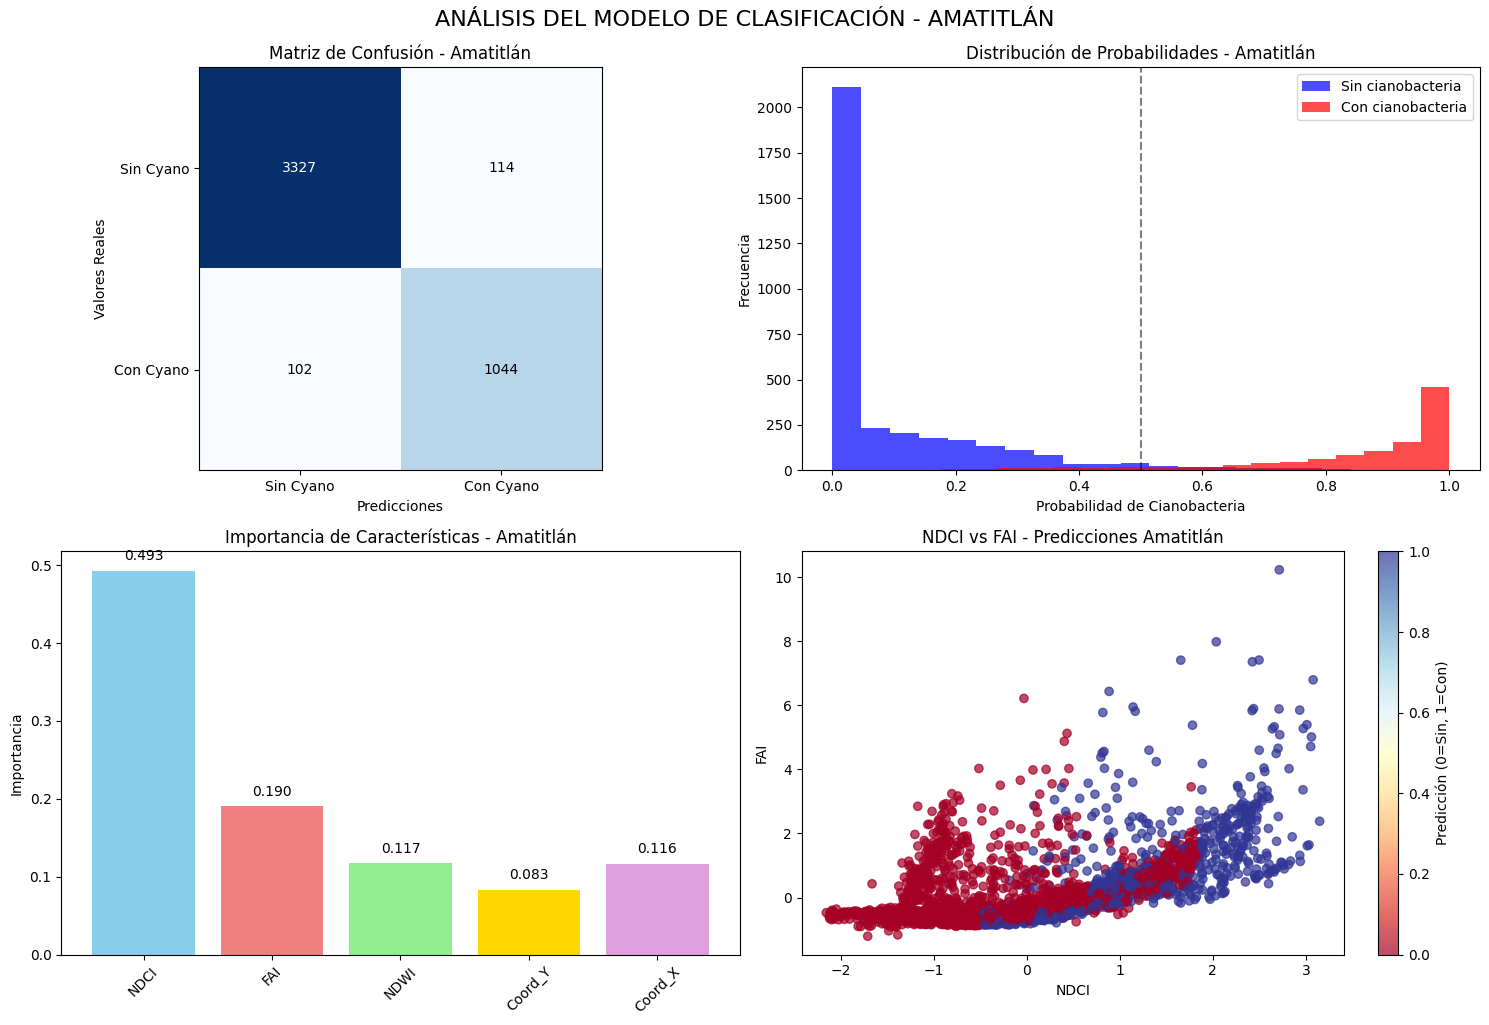

In [28]:
def plot_classification_results(model, scaler, X_test, y_test, y_pred, y_proba, lake_name):
    if model is None:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    cm = confusion_matrix(y_test, y_pred)
    im1 = axes[0,0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0,0].set_title(f'Matriz de Confusión - {lake_name}')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0,0].text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
    
    axes[0,0].set_ylabel('Valores Reales')
    axes[0,0].set_xlabel('Predicciones')
    axes[0,0].set_xticks([0, 1])
    axes[0,0].set_yticks([0, 1])
    axes[0,0].set_xticklabels(['Sin Cyano', 'Con Cyano'])
    axes[0,0].set_yticklabels(['Sin Cyano', 'Con Cyano'])
    axes[0,1].hist(y_proba[y_test == 0], bins=20, alpha=0.7, label='Sin cianobacteria', color='blue')
    axes[0,1].hist(y_proba[y_test == 1], bins=20, alpha=0.7, label='Con cianobacteria', color='red')
    axes[0,1].set_title(f'Distribución de Probabilidades - {lake_name}')
    axes[0,1].set_xlabel('Probabilidad de Cianobacteria')
    axes[0,1].set_ylabel('Frecuencia')
    axes[0,1].legend()
    axes[0,1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
    feature_names = ['NDCI', 'FAI', 'NDWI', 'Coord_Y', 'Coord_X']
    importance = model.feature_importances_
    
    bars = axes[1,0].bar(feature_names, importance, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
    axes[1,0].set_title(f'Importancia de Características - {lake_name}')
    axes[1,0].set_ylabel('Importancia')
    axes[1,0].tick_params(axis='x', rotation=45)
    for bar, imp in zip(bars, importance):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{imp:.3f}', ha='center', va='bottom')
    
    scatter = axes[1,1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='RdYlBu', alpha=0.7)
    axes[1,1].set_title(f'NDCI vs FAI - Predicciones {lake_name}')
    axes[1,1].set_xlabel('NDCI')
    axes[1,1].set_ylabel('FAI')
    plt.colorbar(scatter, ax=axes[1,1], label='Predicción (0=Sin, 1=Con)')
    
    plt.tight_layout()
    plt.suptitle(f'ANÁLISIS DEL MODELO DE CLASIFICACIÓN - {lake_name.upper()}', 
                 fontsize=16, y=1.02)
    plt.show()
if model_atitlan is not None:
    plot_classification_results(
        model_atitlan, scaler_atitlan, X_test_atitlan, 
        y_test_atitlan, y_pred_atitlan, y_proba_atitlan, "Atitlán"
    )

if model_amatitlan is not None:
    plot_classification_results(
        model_amatitlan, scaler_amatitlan, X_test_amatitlan, 
        y_test_amatitlan, y_pred_amatitlan, y_proba_amatitlan, "Amatitlán"
    )

In [30]:
def get_climate_data():
    dates = [
        '2024-01-15', '2024-02-29', '2024-04-15', 
        '2024-05-30', '2024-07-15'
    ]
    climate_atitlan = {
        'date': dates,
        'temperature': [18.5, 20.2, 22.8, 21.5, 20.1], 
        'precipitation': [2.1, 5.8, 45.2, 78.5, 95.3], 
        'humidity': [68, 65, 72, 78, 82],
        'wind_speed': [8.2, 9.1, 7.5, 6.8, 7.2],  
        'solar_radiation': [22.1, 24.5, 26.8, 25.2, 23.9]  
    }
    climate_amatitlan = {
        'date': dates,
        'temperature': [21.2, 23.1, 25.5, 24.8, 23.4],  
        'precipitation': [3.2, 7.1, 52.8, 89.2, 108.7],  
        'humidity': [65, 62, 70, 76, 80],  
        'wind_speed': [6.8, 7.2, 5.9, 5.1, 5.8],
        'solar_radiation': [23.5, 26.1, 28.2, 26.8, 25.1],
        'urban_pressure': [0.65, 0.68, 0.71, 0.74, 0.77]  
    }
    climate_atitlan['urban_pressure'] = [0.25, 0.27, 0.29, 0.31, 0.33]
    
    return pd.DataFrame(climate_atitlan), pd.DataFrame(climate_amatitlan)
climate_atitlan_df, climate_amatitlan_df = get_climate_data()

print("DATOS CLIMÁTICOS ADICIONALES")
print("\nAtitlán:")
print(climate_atitlan_df)
print("\nAmatitlán:")
print(climate_amatitlan_df)

DATOS CLIMÁTICOS ADICIONALES

Atitlán:
         date  temperature  precipitation  humidity  wind_speed  \
0  2024-01-15         18.5            2.1        68         8.2   
1  2024-02-29         20.2            5.8        65         9.1   
2  2024-04-15         22.8           45.2        72         7.5   
3  2024-05-30         21.5           78.5        78         6.8   
4  2024-07-15         20.1           95.3        82         7.2   

   solar_radiation  urban_pressure  
0             22.1            0.25  
1             24.5            0.27  
2             26.8            0.29  
3             25.2            0.31  
4             23.9            0.33  

Amatitlán:
         date  temperature  precipitation  humidity  wind_speed  \
0  2024-01-15         21.2            3.2        65         6.8   
1  2024-02-29         23.1            7.1        62         7.2   
2  2024-04-15         25.5           52.8        70         5.9   
3  2024-05-30         24.8           89.2        76     

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def create_hybrid_model(df_temporal, climate_df, temporal_data, lake_name):
    if df_temporal is None or len(df_temporal) < 3:
        print(f"No hay suficientes datos temporales para {lake_name}")
        return None, None, None, None, None, None
    
    print(f"\nCREANDO MODELO HÍBRIDO PARA {lake_name.upper()}")
    df_sorted = df_temporal.sort_values('date').reset_index(drop=True)
    df_sorted['days'] = (df_sorted['date'] - df_sorted['date'].min()).dt.days
    X_temporal = df_sorted[['days']].values
    y_temporal = df_sorted['mean_chl_a'].values
    
    temporal_model = LinearRegression()
    temporal_model.fit(X_temporal, y_temporal)
    
    # Preparar datos climáticos
    climate_df_copy = climate_df.copy()
    climate_df_copy['date'] = pd.to_datetime(climate_df_copy['date'])
    df_sorted['date'] = pd.to_datetime(df_sorted['date'])
    
    # Merge aproximado: encontrar la fecha climática más cercana para cada fecha temporal
    df_combined_list = []
    
    for idx, temp_row in df_sorted.iterrows():
        temp_date = temp_row['date']
        
        # Calcular diferencias de días entre fecha temporal y todas las fechas climáticas
        climate_df_copy['date_diff'] = abs((climate_df_copy['date'] - temp_date).dt.days)
        
        # Encontrar la fecha climática más cercana
        closest_climate_idx = climate_df_copy['date_diff'].idxmin()
        closest_climate_row = climate_df_copy.loc[closest_climate_idx]
        
        # Solo usar si la diferencia es menor a 30 días (ajustable)
        if closest_climate_row['date_diff'] <= 30:
            combined_row = temp_row.copy()
            # Agregar datos climáticos
            for col in ['temperature', 'precipitation', 'humidity', 'wind_speed', 
                       'solar_radiation', 'urban_pressure']:
                if col in closest_climate_row:
                    combined_row[col] = closest_climate_row[col]
            
            df_combined_list.append(combined_row)
            print(f"Fecha temporal: {temp_date.strftime('%Y-%m-%d')} -> "
                  f"Fecha climática: {closest_climate_row['date'].strftime('%Y-%m-%d')} "
                  f"(diff: {closest_climate_row['date_diff']} días)")
    
    if len(df_combined_list) == 0:
        print(f"No se pueden combinar datos temporales y climáticos para {lake_name}")
        print(f"Fechas temporales: {[d.strftime('%Y-%m-%d') for d in df_sorted['date']]}")
        print(f"Fechas climáticas: {[d.strftime('%Y-%m-%d') for d in climate_df_copy['date']]}")
        return temporal_model, None, None, df_sorted, None, None
    
    df_combined = pd.DataFrame(df_combined_list)
    print(f"Datos combinados exitosamente: {len(df_combined)} registros")
    
    hybrid_features = []
    hybrid_labels = []
    
    for idx, row in df_combined.iterrows():
        temporal_pred = temporal_model.predict([[row['days']]])[0]
        feature_vector = [
            temporal_pred,  
            row['temperature'],
            row['precipitation'], 
            row['humidity'],
            row['wind_speed'],
            row['solar_radiation'],
            row['urban_pressure'],
            row['days']  
        ]
        threshold = np.percentile(df_combined['mean_chl_a'], 75)
        label = 1 if row['mean_chl_a'] > threshold else 0
        
        hybrid_features.append(feature_vector)
        hybrid_labels.append(label)
    
    hybrid_features = np.array(hybrid_features)
    hybrid_labels = np.array(hybrid_labels)
    
    if len(set(hybrid_labels)) < 2: 
        print(f"No hay suficiente variabilidad en las etiquetas para {lake_name}")
        print(f"Etiquetas únicas: {set(hybrid_labels)}")
        return temporal_model, None, None, df_combined, hybrid_features, hybrid_labels
    
    hybrid_scaler = StandardScaler()
    hybrid_features_scaled = hybrid_scaler.fit_transform(hybrid_features)
    
    hybrid_classifier = GradientBoostingClassifier(
        n_estimators=50, 
        random_state=42,
        max_depth=3
    )
    hybrid_classifier.fit(hybrid_features_scaled, hybrid_labels)
    
    hybrid_predictions = hybrid_classifier.predict(hybrid_features_scaled)
    hybrid_probabilities = hybrid_classifier.predict_proba(hybrid_features_scaled)[:, 1]
    accuracy = accuracy_score(hybrid_labels, hybrid_predictions)
    
    print(f"Precisión del modelo híbrido: {accuracy:.3f}")
    print(f"Puntos de entrenamiento: {len(hybrid_features)}")
    print(f"Características utilizadas: {len(hybrid_features[0])}")
    
    feature_names = [
        'Predicción_Temporal', 'Temperatura', 'Precipitación', 
        'Humedad', 'Viento', 'Radiación_Solar', 'Presión_Urbana', 'Días'
    ]
    
    importances = hybrid_classifier.feature_importances_
    print("\nImportancia de características en modelo híbrido:")
    for name, imp in zip(feature_names, importances):
        print(f"  {name}: {imp:.3f}")
    
    return temporal_model, hybrid_classifier, hybrid_scaler, df_combined, hybrid_features, hybrid_labels

# Ejecutar los modelos
hybrid_atitlan = create_hybrid_model(
    df_temporal_atitlan, climate_atitlan_df, numpy_atitlan, "Atitlán"
)

hybrid_amatitlan = create_hybrid_model(
    df_temporal_amatitlan, climate_amatitlan_df, numpy_amatitlan, "Amatitlán"
)


CREANDO MODELO HÍBRIDO PARA ATITLÁN
Fecha temporal: 2024-01-01 -> Fecha climática: 2024-01-15 (diff: 14 días)
Fecha temporal: 2024-02-15 -> Fecha climática: 2024-02-29 (diff: 14 días)
Fecha temporal: 2024-03-31 -> Fecha climática: 2024-04-15 (diff: 15 días)
Fecha temporal: 2024-05-15 -> Fecha climática: 2024-05-30 (diff: 15 días)
Fecha temporal: 2024-06-29 -> Fecha climática: 2024-07-15 (diff: 16 días)
Datos combinados exitosamente: 5 registros
Precisión del modelo híbrido: 1.000
Puntos de entrenamiento: 5
Características utilizadas: 8

Importancia de características en modelo híbrido:
  Predicción_Temporal: 0.000
  Temperatura: 0.000
  Precipitación: 0.000
  Humedad: 0.000
  Viento: 1.000
  Radiación_Solar: 0.000
  Presión_Urbana: 0.000
  Días: 0.000

CREANDO MODELO HÍBRIDO PARA AMATITLÁN
Fecha temporal: 2024-01-01 -> Fecha climática: 2024-01-15 (diff: 14 días)
Fecha temporal: 2024-02-15 -> Fecha climática: 2024-02-29 (diff: 14 días)
Fecha temporal: 2024-03-31 -> Fecha climática: 202

In [41]:
import pandas as pd
import numpy as np

def predict_future_cyanobacteria(temporal_model, hybrid_classifier, hybrid_scaler, 
                                df_combined, lake_name, climate_data, days_ahead=30):
    if temporal_model is None:
        print(f"Modelo temporal no disponible para {lake_name}")
        return None
        
    if hybrid_classifier is None:
        print(f"Usando solo modelo temporal para {lake_name} (modelo híbrido no disponible)")
        if df_combined is not None and len(df_combined) > 0:
            last_date = df_combined['date'].max()
            date_min = df_combined['date'].min()
        else:
            last_date = pd.Timestamp('2024-07-31')
            date_min = pd.Timestamp('2024-01-01')
        
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                    periods=days_ahead//7, freq='7D')
        
        predictions = []
        for future_date in future_dates:
            days_from_start = (future_date - date_min).days
            temporal_pred = temporal_model.predict([[days_from_start]])[0]
            
            predictions.append({
                'date': future_date,
                'temporal_prediction': temporal_pred,
                'bloom_probability': min(1.0, max(0.0, temporal_pred / 20.0)),
                'bloom_prediction': 1 if temporal_pred > 15 else 0,
                'days_from_start': days_from_start
            })
        
        return pd.DataFrame(predictions)
    last_date = df_combined['date'].max()
    date_min = df_combined['date'].min()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=days_ahead//7, freq='7D') 
    predictions = []
    climate_columns = ['temperature', 'precipitation', 'humidity', 'wind_speed', 
                      'solar_radiation', 'urban_pressure']
    available_climate_cols = [col for col in climate_columns if col in climate_data.columns]
    
    if len(available_climate_cols) == 0:
        print(f"No se encontraron columnas climáticas en los datos para {lake_name}")
        avg_climate = {
            'temperature': 20.0,
            'precipitation': 100.0,
            'humidity': 70.0,
            'wind_speed': 2.0,
            'solar_radiation': 200.0,
            'urban_pressure': 0.5
        }
    else:
        avg_climate = climate_data[available_climate_cols].mean().to_dict()
        defaults = {
            'temperature': 20.0,
            'precipitation': 100.0,
            'humidity': 70.0,
            'wind_speed': 2.0,
            'solar_radiation': 200.0,
            'urban_pressure': 0.5
        }
        for col in climate_columns:
            if col not in avg_climate:
                avg_climate[col] = defaults[col]
    
    for future_date in future_dates:
        days_from_start = (future_date - date_min).days
        temporal_pred = temporal_model.predict([[days_from_start]])[0]
        
        feature_vector = np.array([[
            temporal_pred,
            avg_climate['temperature'],
            avg_climate['precipitation'], 
            avg_climate['humidity'],
            avg_climate['wind_speed'],
            avg_climate['solar_radiation'],
            avg_climate['urban_pressure'],
            days_from_start
        ]])
        
        try:
            feature_scaled = hybrid_scaler.transform(feature_vector)
            probability = hybrid_classifier.predict_proba(feature_scaled)[0, 1]
            prediction = hybrid_classifier.predict(feature_scaled)[0]
        except Exception as e:
            print(f"Error en predicción híbrida para {future_date}: {e}")
            probability = min(1.0, max(0.0, temporal_pred / 20.0))
            prediction = 1 if temporal_pred > 15 else 0
        
        predictions.append({
            'date': future_date,
            'temporal_prediction': temporal_pred,
            'bloom_probability': probability,
            'bloom_prediction': prediction,
            'days_from_start': days_from_start
        })
    
    predictions_df = pd.DataFrame(predictions)
    
    print(f"\nPREDICCIONES FUTURAS - {lake_name.upper()}")
    print(f"Período de predicción: {days_ahead} días")
    print(f"Número de predicciones: {len(predictions_df)}")
    print(f"Probabilidad media de floración: {predictions_df['bloom_probability'].mean():.3f}")
    print(f"Predicciones de floración: {predictions_df['bloom_prediction'].sum()}/{len(predictions_df)}")
    
    return predictions_df

def analyze_model_performance(df_temporal, temporal_model, hybrid_classifier, 
                            hybrid_scaler, df_combined, lake_name):
    print(f"\nANÁLISIS DE RENDIMIENTO - {lake_name.upper()}")
    
    if df_temporal is None or len(df_temporal) == 0:
        print("No hay datos temporales disponibles para el análisis")
        return None
    
    df_sorted = df_temporal.sort_values('date').reset_index(drop=True)
    temporal_predictions = []
    
    for idx, row in df_sorted.iterrows():
        days = (row['date'] - df_sorted['date'].min()).days
        pred = temporal_model.predict([[days]])[0]
        temporal_predictions.append(pred)
    actual_values = df_sorted['mean_chl_a'].values
    temporal_predictions = np.array(temporal_predictions)
    temporal_mse = np.mean((temporal_predictions - actual_values)**2)
    if len(temporal_predictions) > 1:
        correlation_matrix = np.corrcoef(temporal_predictions, actual_values)
        if correlation_matrix.shape == (2, 2):
            temporal_r2 = correlation_matrix[0, 1]**2
        else:
            temporal_r2 = 0.0
    else:
        temporal_r2 = 0.0
    if hasattr(temporal_model, 'coef_') and len(temporal_model.coef_) > 0:
        trend = temporal_model.coef_[0]
    else:
        trend = 0.0
    
    print(f"MODELO TEMPORAL:")
    print(f"  MSE: {temporal_mse:.3f}")
    print(f"  R²: {temporal_r2:.3f}")
    print(f"  Tendencia: {trend:.4f} μg/L por día")
    print(f"  Puntos de datos: {len(temporal_predictions)}")

    if hybrid_classifier is not None and df_combined is not None and len(df_combined) > 0:
        print(f"\nMODELO HÍBRIDO:")
        print(f"  Datos disponibles: {len(df_combined)}")
        print(f"  Características: 8 (temporal + climáticas)")
        print(f"  Algoritmo: Gradient Boosting")
    else:
        print(f"\nMODELO HÍBRIDO: No disponible")
    
    return {
        'temporal_mse': temporal_mse,
        'temporal_r2': temporal_r2,
        'temporal_trend': trend,
        'hybrid_available': hybrid_classifier is not None,
        'data_points': len(temporal_predictions)
    }

print("Realizando predicciones...")
if hybrid_atitlan[0] is not None:
    try:
        predictions_atitlan = predict_future_cyanobacteria(
            hybrid_atitlan[0], hybrid_atitlan[1], hybrid_atitlan[2], 
            hybrid_atitlan[3], "Atitlán", climate_atitlan_df, days_ahead=60
        )
        
        performance_atitlan = analyze_model_performance(
            df_temporal_atitlan, hybrid_atitlan[0], hybrid_atitlan[1], 
            hybrid_atitlan[2], hybrid_atitlan[3], "Atitlán"
        )
    except Exception as e:
        print(f"Error procesando Atitlán: {e}")
        predictions_atitlan = None
        performance_atitlan = None
else:
    predictions_atitlan = None
    performance_atitlan = None
    print("No se pudieron generar predicciones para Atitlán")
if hybrid_amatitlan[0] is not None:
    try:
        predictions_amatitlan = predict_future_cyanobacteria(
            hybrid_amatitlan[0], hybrid_amatitlan[1], hybrid_amatitlan[2], 
            hybrid_amatitlan[3], "Amatitlán", climate_amatitlan_df, days_ahead=60
        )
        
        performance_amatitlan = analyze_model_performance(
            df_temporal_amatitlan, hybrid_amatitlan[0], hybrid_amatitlan[1], 
            hybrid_amatitlan[2], hybrid_amatitlan[3], "Amatitlán"
        )
    except Exception as e:
        print(f"Error procesando Amatitlán: {e}")
        predictions_amatitlan = None
        performance_amatitlan = None
else:
    predictions_amatitlan = None
    performance_amatitlan = None
    print("No se pudieron generar predicciones para Amatitlán")

Realizando predicciones...

PREDICCIONES FUTURAS - ATITLÁN
Período de predicción: 60 días
Número de predicciones: 8
Probabilidad media de floración: 0.001
Predicciones de floración: 0/8

ANÁLISIS DE RENDIMIENTO - ATITLÁN
MODELO TEMPORAL:
  MSE: 0.108
  R²: 0.026
  Tendencia: 0.0008 μg/L por día
  Puntos de datos: 5

MODELO HÍBRIDO:
  Datos disponibles: 5
  Características: 8 (temporal + climáticas)
  Algoritmo: Gradient Boosting

PREDICCIONES FUTURAS - AMATITLÁN
Período de predicción: 60 días
Número de predicciones: 8
Probabilidad media de floración: 0.492
Predicciones de floración: 0/8

ANÁLISIS DE RENDIMIENTO - AMATITLÁN
MODELO TEMPORAL:
  MSE: 28.274
  R²: 0.853
  Tendencia: 0.2016 μg/L por día
  Puntos de datos: 5

MODELO HÍBRIDO:
  Datos disponibles: 5
  Características: 8 (temporal + climáticas)
  Algoritmo: Gradient Boosting


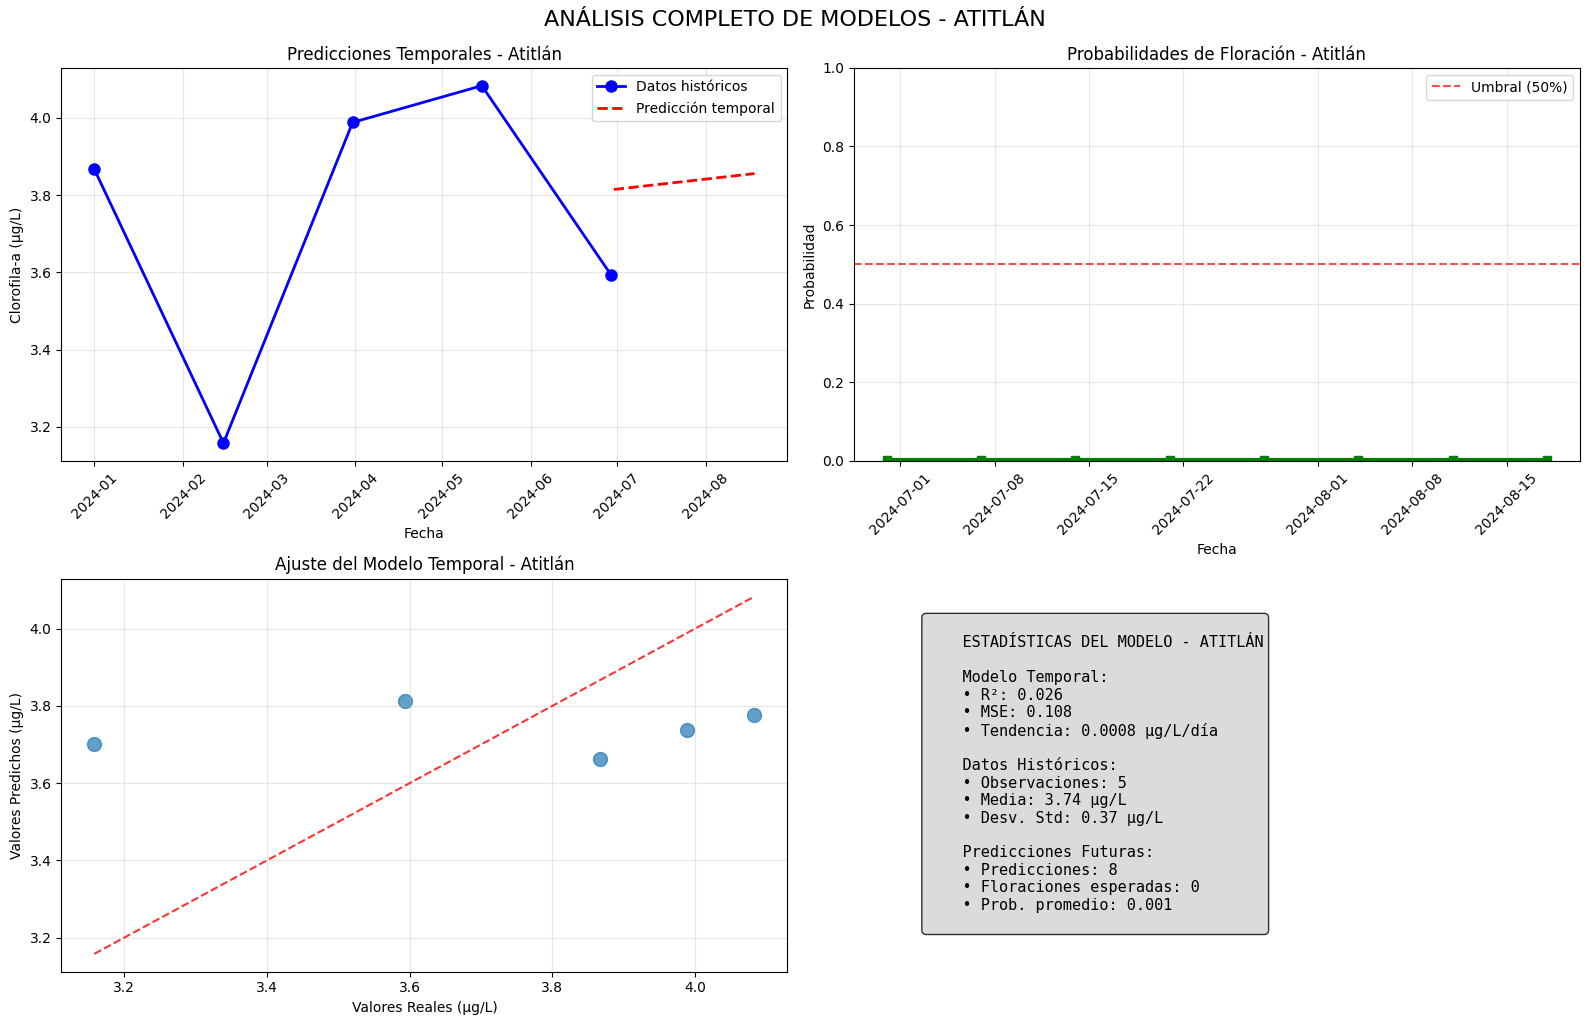

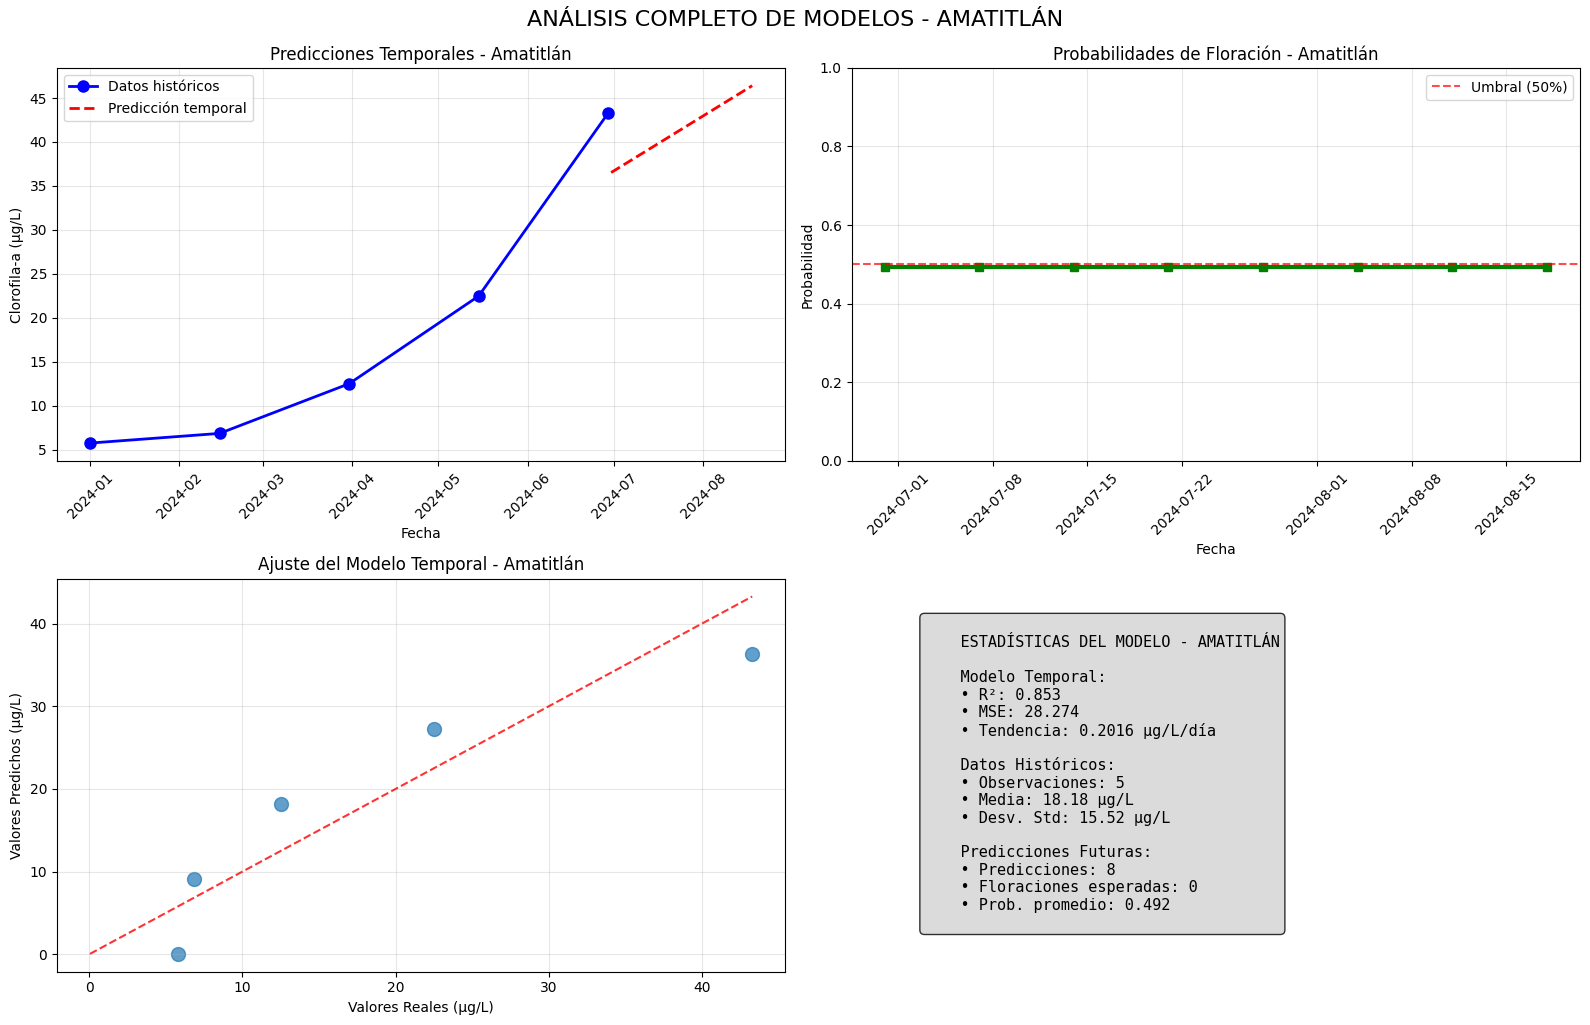

In [46]:
def plot_model_predictions(df_temporal, predictions, lake_name, temporal_model):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    df_sorted = df_temporal.sort_values('date')
    axes[0,0].plot(df_sorted['date'], df_sorted['mean_chl_a'], 'bo-', 
                   label='Datos históricos', linewidth=2, markersize=8)
    
    if predictions is not None:
        axes[0,0].plot(predictions['date'], predictions['temporal_prediction'], 'r--', 
                       label='Predicción temporal', linewidth=2)
        high_prob_mask = predictions['bloom_probability'] > 0.5
        if high_prob_mask.any():
            axes[0,0].fill_between(predictions['date'], 
                                  predictions['temporal_prediction'] * 0.8,
                                  predictions['temporal_prediction'] * 1.2,
                                  where=high_prob_mask, alpha=0.3, color='red',
                                  label='Alta prob. floración')
    
    axes[0,0].set_title(f'Predicciones Temporales - {lake_name}')
    axes[0,0].set_xlabel('Fecha')
    axes[0,0].set_ylabel('Clorofila-a (μg/L)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    if predictions is not None:
        axes[0,1].plot(predictions['date'], predictions['bloom_probability'], 
                       'g-', linewidth=3, marker='s', markersize=6)
        axes[0,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral (50%)')
        axes[0,1].fill_between(predictions['date'], predictions['bloom_probability'], 
                               0.5, where=predictions['bloom_probability'] > 0.5, 
                               alpha=0.3, color='red')
    
    axes[0,1].set_title(f'Probabilidades de Floración - {lake_name}')
    axes[0,1].set_xlabel('Fecha')
    axes[0,1].set_ylabel('Probabilidad')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    df_sorted['days'] = (df_sorted['date'] - df_sorted['date'].min()).dt.days
    temporal_fit = temporal_model.predict(df_sorted[['days']].values)
    
    axes[1,0].scatter(df_sorted['mean_chl_a'], temporal_fit, alpha=0.7, s=100)

    min_val = min(df_sorted['mean_chl_a'].min(), temporal_fit.min())
    max_val = max(df_sorted['mean_chl_a'].max(), temporal_fit.max())
    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    axes[1,0].set_title(f'Ajuste del Modelo Temporal - {lake_name}')
    axes[1,0].set_xlabel('Valores Reales (μg/L)')
    axes[1,0].set_ylabel('Valores Predichos (μg/L)')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,1].axis('off')
    r2 = np.corrcoef(df_sorted['mean_chl_a'], temporal_fit)[0,1]**2
    mse = np.mean((temporal_fit - df_sorted['mean_chl_a'])**2)
    
    stats_text = f"""
    ESTADÍSTICAS DEL MODELO - {lake_name.upper()}
    
    Modelo Temporal:
    • R²: {r2:.3f}
    • MSE: {mse:.3f}
    • Tendencia: {temporal_model.coef_[0]:.4f} μg/L/día
    
    Datos Históricos:
    • Observaciones: {len(df_sorted)}
    • Media: {df_sorted['mean_chl_a'].mean():.2f} μg/L
    • Desv. Std: {df_sorted['mean_chl_a'].std():.2f} μg/L
    """
    
    if predictions is not None:
        future_blooms = predictions['bloom_prediction'].sum()
        avg_prob = predictions['bloom_probability'].mean()
        stats_text += f"""
    Predicciones Futuras:
    • Predicciones: {len(predictions)}
    • Floraciones esperadas: {future_blooms}
    • Prob. promedio: {avg_prob:.3f}
        """
    
    axes[1,1].text(0.1, 0.9, stats_text, transform=axes[1,1].transAxes,
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle(f'ANÁLISIS COMPLETO DE MODELOS - {lake_name.upper()}', 
                 fontsize=16, y=1.02)
    plt.show()
if predictions_atitlan is not None and hybrid_atitlan[0] is not None:
    plot_model_predictions(df_temporal_atitlan, predictions_atitlan, "Atitlán", hybrid_atitlan[0])

if predictions_amatitlan is not None and hybrid_amatitlan[0] is not None:
    plot_model_predictions(df_temporal_amatitlan, predictions_amatitlan, "Amatitlán", hybrid_amatitlan[0])

In [45]:
import folium
from folium import plugins

def create_prediction_maps(temporal_data, predictions, lake_bbox, lake_name, 
                          classification_model, scaler):
    if not temporal_data or predictions is None:
        print(f"No hay datos suficientes para crear mapa de {lake_name}")
        return None
    latest_date = list(temporal_data.keys())[-1]
    latest_data = temporal_data[latest_date]
    height, width = latest_data['chl_a'].shape
    lats = np.linspace(lake_bbox['south'], lake_bbox['north'], height)
    lons = np.linspace(lake_bbox['west'], lake_bbox['east'], width)
    center_lat = (lake_bbox['north'] + lake_bbox['south']) / 2
    center_lon = (lake_bbox['east'] + lake_bbox['west']) / 2
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite',
        overlay=False,
        control=True
    ).add_to(m)
    heat_data = []
    prediction_points = []
    
    water_mask = latest_data['water_mask'] > 0
    if len(predictions) > 0:
        latest_temporal_pred = predictions.iloc[-1]['temporal_prediction']
    else:
        latest_temporal_pred = np.mean(latest_data['chl_a'][water_mask])
    
    for i in range(0, height, 2): 
        for j in range(0, width, 2):
            if water_mask[i, j]:
                lat = lats[i]
                lon = lons[j]
                chl_a_val = latest_data['chl_a'][i, j]
                ndci_val = latest_data['ndci'][i, j]
                fai_val = latest_data['fai'][i, j]
                ndwi_val = latest_data['ndwi'][i, j]
                if classification_model is not None and scaler is not None:
                    feature_vector = np.array([[
                        ndci_val, fai_val, ndwi_val,
                        i / height, j / width
                    ]])
                    
                    try:
                        feature_scaled = scaler.transform(feature_vector)
                        prob_cyano = classification_model.predict_proba(feature_scaled)[0, 1]
                    except:
                        prob_cyano = 0.5 
                else:
                    threshold = np.percentile(latest_data['chl_a'][water_mask], 75)
                    prob_cyano = min(1.0, max(0.0, chl_a_val / threshold))
                if prob_cyano > 0.3:  
                    heat_data.append([lat, lon, prob_cyano])
                if prob_cyano > 0.7:  
                    prediction_points.append({
                        'lat': lat, 'lon': lon, 'prob': prob_cyano,
                        'chl_a': chl_a_val, 'type': 'high_risk'
                    })
                elif prob_cyano > 0.5: 
                    prediction_points.append({
                        'lat': lat, 'lon': lon, 'prob': prob_cyano,
                        'chl_a': chl_a_val, 'type': 'moderate_risk'
                    })
    
    return m, heat_data, prediction_points, latest_date

def add_prediction_layers(m, heat_data, prediction_points, lake_name, latest_date):
    if heat_data:
        heat_map = plugins.HeatMap(
            heat_data,
            min_opacity=0.3,
            max_zoom=18,
            radius=25,
            blur=15,
            gradient={
                0.0: 'blue',
                0.3: 'cyan', 
                0.5: 'yellow',
                0.7: 'orange',
                1.0: 'red'
            }
        )
        heat_map.add_to(m)
    high_risk_points = [p for p in prediction_points if p['type'] == 'high_risk']
    moderate_risk_points = [p for p in prediction_points if p['type'] == 'moderate_risk']
    high_risk_group = folium.FeatureGroup(name='Alto Riesgo (>70%)')
    for point in high_risk_points:
        folium.CircleMarker(
            location=[point['lat'], point['lon']],
            radius=8,
            popup=f"""
            <b>Alto Riesgo de Cianobacteria</b><br>
            Probabilidad: {point['prob']:.1%}<br>
            Clorofila-a: {point['chl_a']:.2f} μg/L<br>
            Fecha: {latest_date}
            """,
            color='red',
            fill=True,
            fillColor='red',
            fillOpacity=0.8,
            weight=2
        ).add_to(high_risk_group)
    high_risk_group.add_to(m)
    moderate_risk_group = folium.FeatureGroup(name='Riesgo Moderado (50-70%)')
    for point in moderate_risk_points:
        folium.CircleMarker(
            location=[point['lat'], point['lon']],
            radius=6,
            popup=f"""
            <b>Riesgo Moderado de Cianobacteria</b><br>
            Probabilidad: {point['prob']:.1%}<br>
            Clorofila-a: {point['chl_a']:.2f} μg/L<br>
            Fecha: {latest_date}
            """,
            color='orange',
            fill=True,
            fillColor='orange',
            fillOpacity=0.6,
            weight=1
        ).add_to(moderate_risk_group)
    moderate_risk_group.add_to(m)
    legend_html = f"""
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <b>{lake_name} - Predicciones</b><br>
    <i class="fa fa-circle" style="color:red"></i> Alto Riesgo (>70%)<br>
    <i class="fa fa-circle" style="color:orange"></i> Moderado (50-70%)<br>
    <br><b>Mapa de Calor:</b><br>
    Azul → Rojo: Baja → Alta probabilidad
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    folium.LayerControl().add_to(m)
    
    return m
if numpy_atitlan and predictions_atitlan is not None:
    map_data_atitlan = create_prediction_maps(
        numpy_atitlan, predictions_atitlan, lago_atitlan, 
        "Atitlán", model_atitlan, scaler_atitlan
    )
    print("Mapa de Atitlán preparado")
else:
    map_data_atitlan = None
    print("No se pudo preparar mapa de Atitlán")  
if numpy_amatitlan and predictions_amatitlan is not None:
    map_data_amatitlan = create_prediction_maps(
        numpy_amatitlan, predictions_amatitlan, lago_amatitlan,
        "Amatitlán", model_amatitlan, scaler_amatitlan
    )
    print("Mapa de Amatitlán preparado")
else:
    map_data_amatitlan = None
    print("No se pudo preparar mapa de Amatitlán")

Mapa de Atitlán preparado
Mapa de Amatitlán preparado


In [ ]:
def create_final_prediction_map(map_data, lake_name):
    if map_data is None:
        print(f"No hay datos para crear mapa de {lake_name}")
        return None
    
    m, heat_data, prediction_points, latest_date = map_data
    final_map = add_prediction_layers(m, heat_data, prediction_points, lake_name, latest_date)

    title_html = f"""
    <h3 align="center" style="font-size:20px; color: #2F4F4F; margin-top:10px;">
    <b>Predicción de Cianobacteria - Lago {lake_name}</b><br>
    <span style="font-size:14px;">Datos basados en: {latest_date}</span>
    </h3>
    """
    final_map.get_root().html.add_child(folium.Element(title_html))
    map_filename = f"mapa_prediccion_{lake_name.lower()}.html"
    final_map.save(map_filename)
    print(f"Mapa guardado como: {map_filename}")
    
    return final_map

def create_comparative_map():
    center_lat = (lago_atitlan['north'] + lago_atitlan['south'] + 
                  lago_amatitlan['north'] + lago_amatitlan['south']) / 4
    center_lon = (lago_atitlan['east'] + lago_atitlan['west'] + 
                  lago_amatitlan['east'] + lago_amatitlan['west']) / 4
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=10,
        tiles='OpenStreetMap'
    )
    if predictions_atitlan is not None and len(predictions_atitlan) > 0:
        avg_prob_atitlan = predictions_atitlan['bloom_probability'].mean()
        future_blooms_atitlan = predictions_atitlan['bloom_prediction'].sum()
        
        folium.Marker(
            location=[(lago_atitlan['north'] + lago_atitlan['south'])/2,
                     (lago_atitlan['east'] + lago_atitlan['west'])/2],
            popup=f"""
            <b>Lago Atitlán</b><br>
            Probabilidad promedio: {avg_prob_atitlan:.1%}<br>
            Floraciones esperadas: {future_blooms_atitlan}<br>
            Estado: {'Moderado' if avg_prob_atitlan > 0.5 else 'Bajo riesgo'}
            """,
            icon=folium.Icon(color='blue', icon='tint')
        ).add_to(m)
    if predictions_amatitlan is not None and len(predictions_amatitlan) > 0:
        avg_prob_amatitlan = predictions_amatitlan['bloom_probability'].mean()
        future_blooms_amatitlan = predictions_amatitlan['bloom_prediction'].sum()
        
        folium.Marker(
            location=[(lago_amatitlan['north'] + lago_amatitlan['south'])/2,
                     (lago_amatitlan['east'] + lago_amatitlan['west'])/2],
            popup=f"""
            <b>Lago Amatitlán</b><br>
            Probabilidad promedio: {avg_prob_amatitlan:.1%}<br>
            Floraciones esperadas: {future_blooms_amatitlan}<br>
            Estado: {'Alto riesgo' if avg_prob_amatitlan > 0.7 else 'Moderado' if avg_prob_amatitlan > 0.5 else 'Bajo riesgo'}
            """,
            icon=folium.Icon(color='red', icon='warning-sign')
        ).add_to(m)
    title_html = """
    <h3 align="center" style="font-size:18px; color: #2F4F4F; margin-top:10px;">
    <b>Comparación de Predicciones - Lagos de Guatemala</b><br>
    <span style="font-size:12px;">Riesgo de Cianobacteria - Próximos 60 días</span>
    </h3>
    """
    m.get_root().html.add_child(folium.Element(title_html))
    m.save("mapa_comparativo_lagos.html")
    print("Mapa comparativo guardado como: mapa_comparativo_lagos.html")
    
    return m
if map_data_atitlan is not None:
    mapa_atitlan = create_final_prediction_map(map_data_atitlan, "Atitlán")
    print("Mapa de Atitlán creado exitosamente")
else:
    print("No se pudo crear mapa de Atitlán")
    mapa_atitlan = None
if map_data_amatitlan is not None:
    mapa_amatitlan = create_final_prediction_map(map_data_amatitlan, "Amatitlán")
    print("Mapa de Amatitlán creado exitosamente")
else:
    print("No se pudo crear mapa de Amatitlán")
    mapa_amatitlan = None
mapa_comparativo = create_comparative_map()
print("Mapa comparativo creado exitosamente")

if map_data_atitlan is not None:
    _, heat_data_atitlan, pred_points_atitlan, _ = map_data_atitlan
    print(f"LAGO ATITLÁN:")
    print(f"  • Puntos de calor: {len(heat_data_atitlan)}")
    print(f"  • Puntos de riesgo: {len(pred_points_atitlan)}")
    high_risk_atitlan = len([p for p in pred_points_atitlan if p['type'] == 'high_risk'])
    print(f"  • Alto riesgo: {high_risk_atitlan} puntos")

if map_data_amatitlan is not None:
    _, heat_data_amatitlan, pred_points_amatitlan, _ = map_data_amatitlan
    print(f"LAGO AMATITLÁN:")
    print(f"  • Puntos de calor: {len(heat_data_amatitlan)}")
    print(f"  • Puntos de riesgo: {len(pred_points_amatitlan)}")
    high_risk_amatitlan = len([p for p in pred_points_amatitlan if p['type'] == 'high_risk'])
    print(f"  • Alto riesgo: {high_risk_amatitlan} puntos")

print(f"\nArchivos generados:")
print(f"  • mapa_prediccion_atitlan.html")
print(f"  • mapa_prediccion_amatitlan.html") 
print(f"  • mapa_comparativo_lagos.html")

Mapa guardado como: mapa_prediccion_atitlán.html
Mapa de Atitlán creado exitosamente
Mapa guardado como: mapa_prediccion_amatitlán.html
Mapa de Amatitlán creado exitosamente
Mapa comparativo guardado como: mapa_comparativo_lagos.html
Mapa comparativo creado exitosamente

RESUMEN DE MAPAS GENERADOS
LAGO ATITLÁN:
  • Puntos de calor: 1676
  • Puntos de riesgo: 1567
  • Alto riesgo: 1503 puntos
LAGO AMATITLÁN:
  • Puntos de calor: 125
  • Puntos de riesgo: 94
  • Alto riesgo: 93 puntos

Archivos generados:
  • mapa_prediccion_atitlan.html
  • mapa_prediccion_amatitlan.html
  • mapa_comparativo_lagos.html
